## Import

In [151]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns
from google.cloud import storage
import math
import requests
import bs4
import re
import ast
import pickle
import my_functions as utils

from scipy.stats import norm
import sklearn.ensemble as en
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn import model_selection as ms
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_classif

import optuna
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', 100)

import importlib

importlib.reload(utils)

<module 'my_functions' from '/home/arthur/projetos/DSBD/artigo/my_functions.py'>

## Carregando Dados

In [ ]:
# bucket_name='busca-apartamentos-bucket'

# datas = utils.get_all_dates(bucket_name=bucket_name)

# dados_cilar = utils.get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['cilar'])
# dados_apolar = utils.get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['apolar'])
# dados_razao = utils.get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['razao'])
# dados_razao = dados_razao.loc[dados_razao['data_coleta'] >= '2024-10-21']

# utils.save_parquet_file(file=dados_cilar, name='data/dados_cilar')
# utils.save_parquet_file(file=dados_apolar, name='data/dados_apolar')

dados_cilar = utils.load_parquet_file(name='data/dados_cilar')
dados_apolar = utils.load_parquet_file(name='data/dados_apolar')

### Removendo duplicatas

In [9]:
# # removendo duplicatas e mantendo os mais recentes
dados_cilar_reduce = dados_cilar.sort_values('data_coleta').drop_duplicates('link', keep = 'last')

# # removendo duplicatas e mantendo os mais recentes
dados_apolar_reduce = dados_apolar.sort_values('data_coleta').drop_duplicates('link', keep = 'last')

### Tratando dados Raw

- Tratando variáveis: Aluguel, condomínio, iptu, seguro_incendio, cidade, bairro, área, quartos, banheiros, suites, vagas de garagem
- Criando variáveis: mobiliado, sacada, academia, piscina, churrasqueira, salão de festas

In [15]:
df_cilar_trusted.dtypes

site                       object
data_coleta                object
titulo                     object
link                       object
endereco                   object
detalhes                   object
aluguel                   float64
condominio                float64
iptu                      float64
caracteristicas_imovel     object
detalhes_condominio        object
mais_detalhes_imovel       object
area                        int64
quartos                   float64
suites                    float64
banheiros                 float64
andar                     float64
vagas_garagem             float64
bairro                     object
cidade                     object
mobiliado                  object
mobilia_planejada          object
piscina                    object
academia                   object
sacada                     object
churrasqueira              object
salao_de_festas            object
salao_de_jogos             object
espaco_coworking           object
quadra_esporte

In [21]:
df_apolar_trusted.dtypes

site                     object
data_coleta              object
titulo                   object
link                     object
endereco                 object
valores                  object
atributos                object
descricao                object
ficha_tecnica            object
bairro                   object
cidade                   object
aluguel                 float64
condominio              float64
iptu                    float64
seguro_incendio         float64
area                     object
banheiros                object
quartos                  object
suites                   object
vagas_garagem            object
mobiliado                object
mobilia_planejada        object
piscina                  object
academia                 object
sacada                   object
churrasqueira            object
salao_de_festas          object
salao_de_jogos           object
espaco_coworking         object
quadra_esportes          object
playground               object
lavander

In [23]:
df_cilar_trusted = utils.tratamento_dados_cilar(dados_cilar_reduce)
df_apolar_trusted = utils.tratamento_dados_apolar(dados_apolar_reduce)
# df_razao_trusted = tratamento_dados_razao(dados_razao)

utils.save_parquet_file(file=df_cilar_trusted, name='data/df_cilar_trusted')
utils.save_parquet_file(file=df_apolar_trusted, name='data/df_apolar_trusted')

df_cilar_trusted = utils.load_parquet_file(name='data/df_cilar_trusted')
df_apolar_trusted = utils.load_parquet_file(name='data/df_apolar_trusted')

### Reunindo em um único dataset

In [24]:
columns_selected = [
'site',
'data_coleta',
'titulo',
'link',
'endereco',
'cidade',
'bairro',
'aluguel',
'condominio',
'iptu',
'area',
'quartos',
'suites',
'banheiros',
'vagas_garagem',
'mobiliado', 
'mobilia_planejada',
'piscina', 
'academia', 
'sacada',
'churrasqueira', 
'salao_de_festas',
'salao_de_jogos',
'espaco_coworking', 
'quadra_esportes', 
'playground', 
'lavanderia',
'espaco_pet', 
'imovel_decorado',
'totalmente_mobiliado',
'hidromassagem'
]


# reunindo datasets
df_full = pd.concat([df_cilar_trusted[columns_selected], df_apolar_trusted[columns_selected]], axis=0)
# df_full = pd.concat([df_full[columns_selected], df_razao_trusted[columns_selected]], axis=0)
df_full = df_full.loc[df_full['cidade'].str.lower() == 'curitiba']

# removendo duplicatas e mantendo os mais recentes
df_full = df_full.sort_values('data_coleta').drop_duplicates('link', keep = 'last')
df_full = df_full.loc[df_full['data_coleta'] <= '2025-03-20']

In [25]:
df_full.shape[0]

8484

## Análise Descritiva dos Dados

In [26]:
df_ana_desc = df_full.copy()
df_ana_desc.to_pickle('params/data/df_analise_descritiva.pkl')
df_ana_desc = pd.read_pickle('params/data/df_analise_descritiva.pkl')

#### Valores Nulos

In [27]:
# removendo erros no dataset

df_ana_desc = df_ana_desc.dropna(subset=['aluguel'])
df_ana_desc = df_ana_desc.dropna(subset=['endereco'])
df_ana_desc = df_ana_desc.dropna(subset=['area'])
df_ana_desc = df_ana_desc.fillna('Não')

In [28]:
df_ana_desc.shape[0]

8448

#### Tipos de Dados

In [29]:
df_ana_desc['bairro'] = df_ana_desc['bairro'].str.strip().str.lower()
df_ana_desc['data_coleta'] = pd.to_datetime(df_ana_desc['data_coleta'])
df_ana_desc['area'] = df_ana_desc['area'].astype('float64')
df_ana_desc['quartos'] = df_ana_desc['quartos'].astype('int64')
df_ana_desc['suites'] = df_ana_desc['suites'].astype('int64')
df_ana_desc['banheiros']  = df_ana_desc['banheiros'].astype('int64')
df_ana_desc['vagas_garagem'] =  df_ana_desc['vagas_garagem'].astype('int64')

## Filtrando Dataset

In [30]:
df_filter = df_ana_desc.copy()
df_filter.to_pickle('params/data/df_filter.pkl')
df_filter = pd.read_pickle('params/data/df_filter.pkl')

In [31]:
# considerar somente imóveis abaixo de 10k 
df_filter = df_filter.loc[df_filter['aluguel'] <= 6000]
df_filter = df_filter.loc[df_filter['condominio'] <= 2000]
df_filter = df_filter.loc[df_filter['iptu'] <= 2000]
df_filter = df_filter.loc[df_filter['aluguel'] + df_filter['condominio'] + df_filter['iptu'] <= 6000]

# considerar somente imóveis com área maior que 0
df_filter = df_filter.loc[df_filter['area'] > 0]
df_filter = df_filter.loc[df_filter['area'] < 250]

# considerar somente imoveis com número de quartos maior que 0
df_filter = df_filter.loc[df_filter['quartos'] > 0]
df_filter = df_filter.loc[df_filter['quartos'] < 5]

# Considerar somente imóveis com banheiros ou suítes
df_filter = df_filter.loc[(df_filter['banheiros'] > 0) | (df_filter['suites'] > 0) ]

# Considerar somente imóveis com valor de aluguel maior que 0
df_filter = df_filter.loc[df_filter['aluguel'] > 0]

## Feature Engineering

link IBGE: https://www.ibge.gov.br/estatisticas/downloads-estatisticas.html

In [32]:
df_filter.shape[0]

7296

In [33]:
df_feature_engineering = df_filter.copy()
df_feature_engineering.to_pickle('params/data/df_feature_engineering.pkl')
df_feature_engineering = pd.read_pickle('params/data/df_feature_engineering.pkl')

### Valor total

In [34]:
df_feature_engineering['valor_total'] = df_feature_engineering['aluguel'] + df_feature_engineering['condominio'] +  df_feature_engineering['iptu'] 

### Data de Coleta

In [35]:
# year
df_feature_engineering['year'] = df_feature_engineering['data_coleta'].dt.year
# month
df_feature_engineering['month'] = df_feature_engineering['data_coleta'].dt.month

# day
df_feature_engineering['day'] = df_feature_engineering['data_coleta'].dt.day

# week of day
df_feature_engineering['week_of_year'] = df_feature_engineering['data_coleta'].dt.isocalendar().week


### Latitude e Longitude

In [36]:
# dict_lat_long = aux_lat_long.to_dict('index')
df_lat_long = pd.DataFrame(utils.load_picked_file(name='lat_longs')).T

df_feature_engineering = pd.merge(df_feature_engineering, df_lat_long[['link', 'latitude', 'longitude']], on = 'link', how='left')

df_feature_engineering = df_feature_engineering.dropna(subset=['latitude'])

df_feature_engineering = df_feature_engineering.loc[(df_feature_engineering['latitude'].astype('int64') == -25) & (df_feature_engineering['longitude'].astype('int64') == -49)]

In [37]:
df_feature_engineering.shape[0]

7052

### Dados Demográficos

In [38]:
dados_curitiba = utils.get_infos_curitiba()
dados_curitiba.to_csv('dados_curitiba.csv', index=False)

In [39]:
dados_curitiba = utils.get_infos_curitiba()

ajustes = {
    'ecoville':'mossungue',
    'champagnat':'bigorrilho',
    'bigoriilho':'bigorrilho',
    'alto da rua xv': 'alto da xv',
    'novo mundo ': 'novo mundo',
    'jd. das americas': 'jardim das americas',
    'cic':'cidade industrial'
}

# ajustando nome dos bairros
df_feature_engineering['bairro'] = df_feature_engineering['bairro'].replace(ajustes)
df_feature_engineering['bairro'] = df_feature_engineering['bairro'].apply(lambda x: unidecode(x))

# cruzando dados da wikipedia 
df_feature_engineering = pd.merge(df_feature_engineering, dados_curitiba, on = 'bairro', how ='left')
df_feature_engineering = df_feature_engineering.dropna()

# tratando dados da wikipedia
df_feature_engineering['qtd_domicilios_particulares'] = df_feature_engineering['qtd_domicilios_particulares'].astype('int64')
df_feature_engineering['renda_media_responsaveis_domicilio'] = df_feature_engineering['renda_media_responsaveis_domicilio'].astype('float64')

In [40]:
df_feature_engineering.shape[0]

7021

### Resumo Datasets

In [41]:
import plotly.graph_objects as go

# Exemplo de dados
etapas = ['Total Inicial', 'Nulos (area, aluguel, endereco)', 'Casos extremos', 'Endereços desconhecidos', 'Final']
tamanhos_datasets = [8597, 8559, 7374, 7099]

valores = [
    tamanhos_datasets[0],
    -(tamanhos_datasets[0] - tamanhos_datasets[1]),
    -(tamanhos_datasets[1] - tamanhos_datasets[2]),
    -(tamanhos_datasets[2] - tamanhos_datasets[3]),
    tamanhos_datasets[3]
]

# Cores personalizadas
cores = ['#003f5c' if v >= 0 else '#d62728' for v in valores]  # Azul escuro e vermelho

fig = go.Figure(go.Waterfall(
    name="Redução do Dataset",
    orientation="v",
    measure=["absolute", "relative", "relative", "relative", "absolute"],
    x=etapas,
    y=valores,
    text=[f"{v}" for v in valores],
    connector={"line": {"color": "gray"}},
    increasing={"marker": {"color": "#003f5c"}},  # Azul escuro
    decreasing={"marker": {"color": "#d62728"}},  # Vermelho
    totals={"marker": {"color": "#003f5c"}}       # Total final em azul escuro também
))

# Layout com fundo branco
fig.update_layout(
    title="Redução do Dataset por Etapas",
    plot_bgcolor='white',
    paper_bgcolor='white',
    waterfallgap=0.3,
    font=dict(size=14),
    xaxis=dict(title="Etapas"),
    yaxis=dict(title="Quantidade"),
    width=900,     # Largura em pixels
    height=500     # Altura em pixels
)

fig.show()


## Análise Exploratória dos Dados

- Análise Univariada
- Análise Bivariada
- Análise Multivariada

### Análise Univariada

In [42]:
df_exp = df_feature_engineering.copy()
df_exp.to_pickle('params/data/df_exp.pkl')
df_exp = pd.read_pickle('params/data/df_exp.pkl')

LAYOUT_PALETTE = 'dark'
sns.set_palette(LAYOUT_PALETTE)

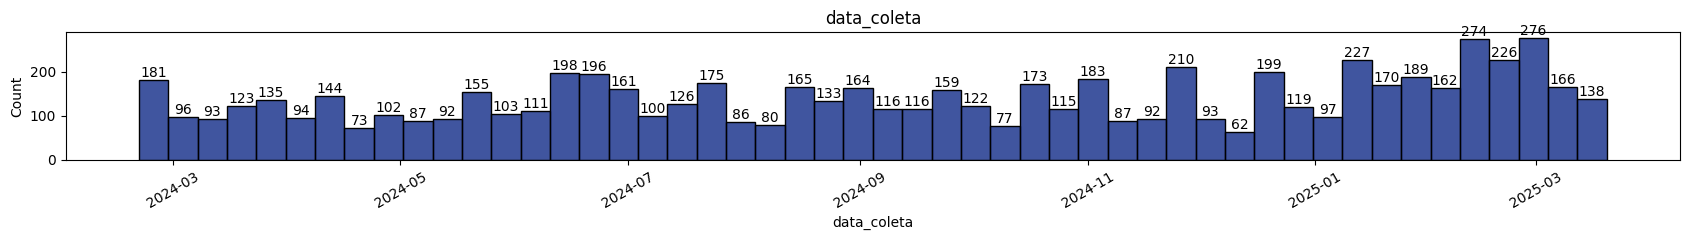

In [43]:
utils.plot_matrix(
    data=df_exp, 
    columns_features=['data_coleta'], 
    n_rows = 1, 
    n_cols = 1, 
    figsize=(17, 2.5), 
    plot = sns.histplot, 
    plot_kwargs={'bins':50}, 
    loop_feature = 'x' ,
    label=True)

Gráfico salvo em: images/analise_univariada_dados_imovel.png


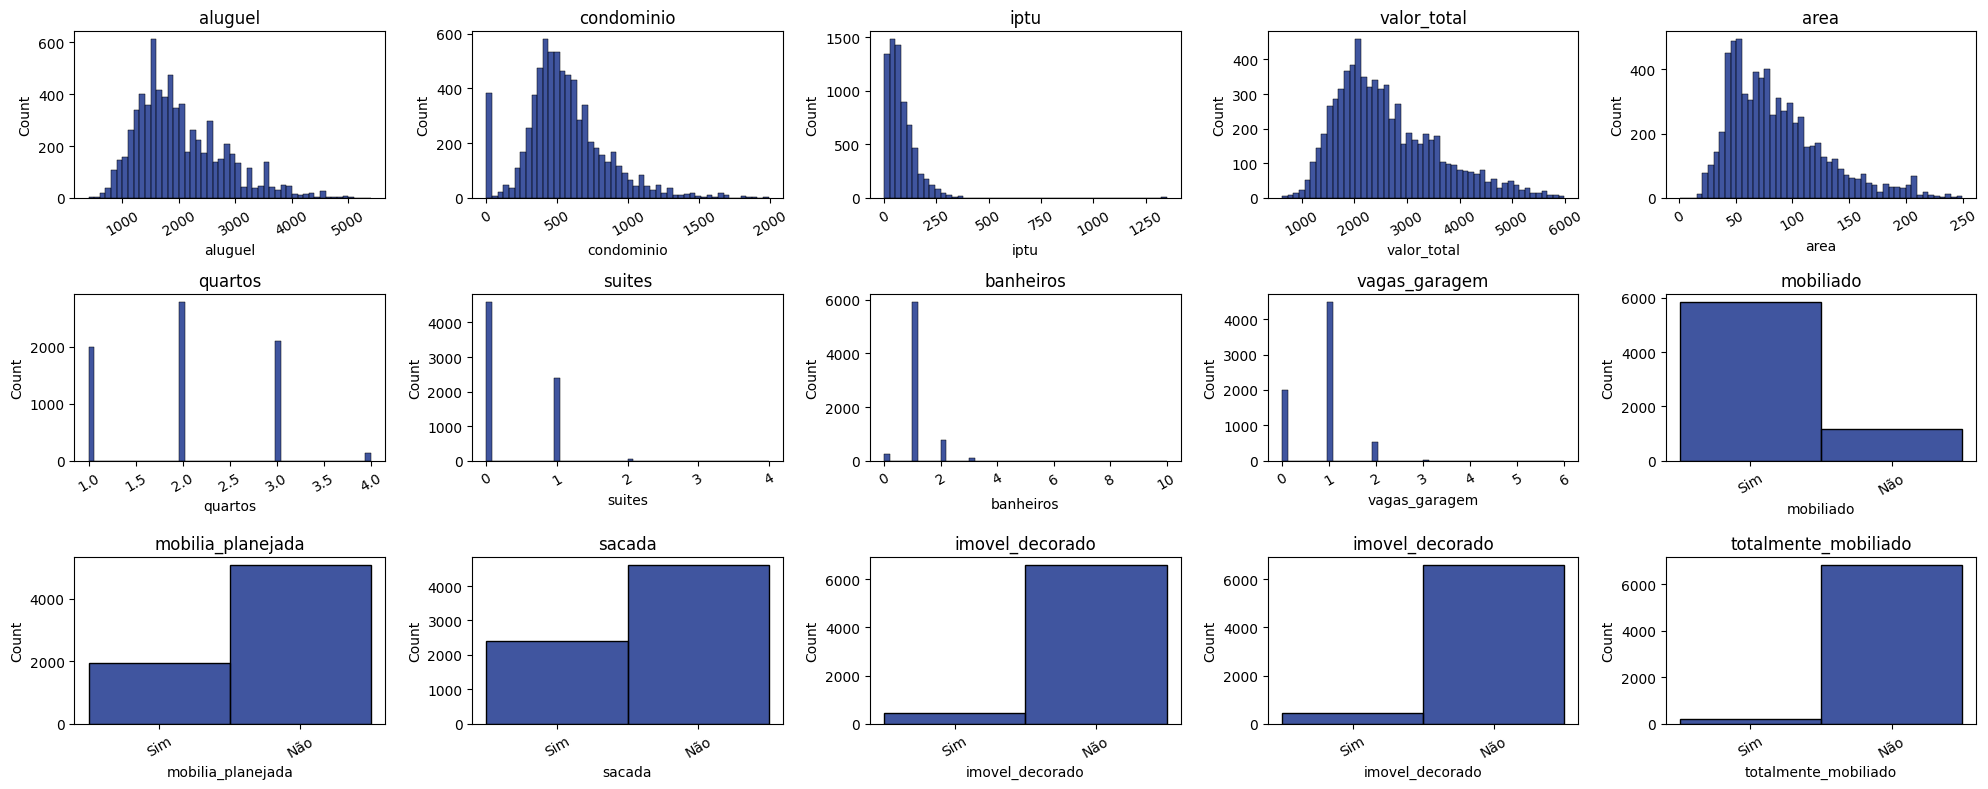

In [44]:
columns_features = ['aluguel', 'condominio', 'iptu','valor_total', 'area', 'quartos', 'suites',
       'banheiros', 'vagas_garagem', 'mobiliado', 'mobilia_planejada', 'sacada', 'imovel_decorado','imovel_decorado', 'totalmente_mobiliado']


utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    n_rows = 3, 
    n_cols = 5, 
    figsize=(20, 8), 
    plot = sns.histplot, 
    plot_kwargs={'bins':50}, 
    loop_feature = 'x' ,
    label=False,
    save_image=True,
    nome_imagem='analise_univariada_dados_imovel')

Gráfico salvo em: images/analise_univariada_dados_condominio.png


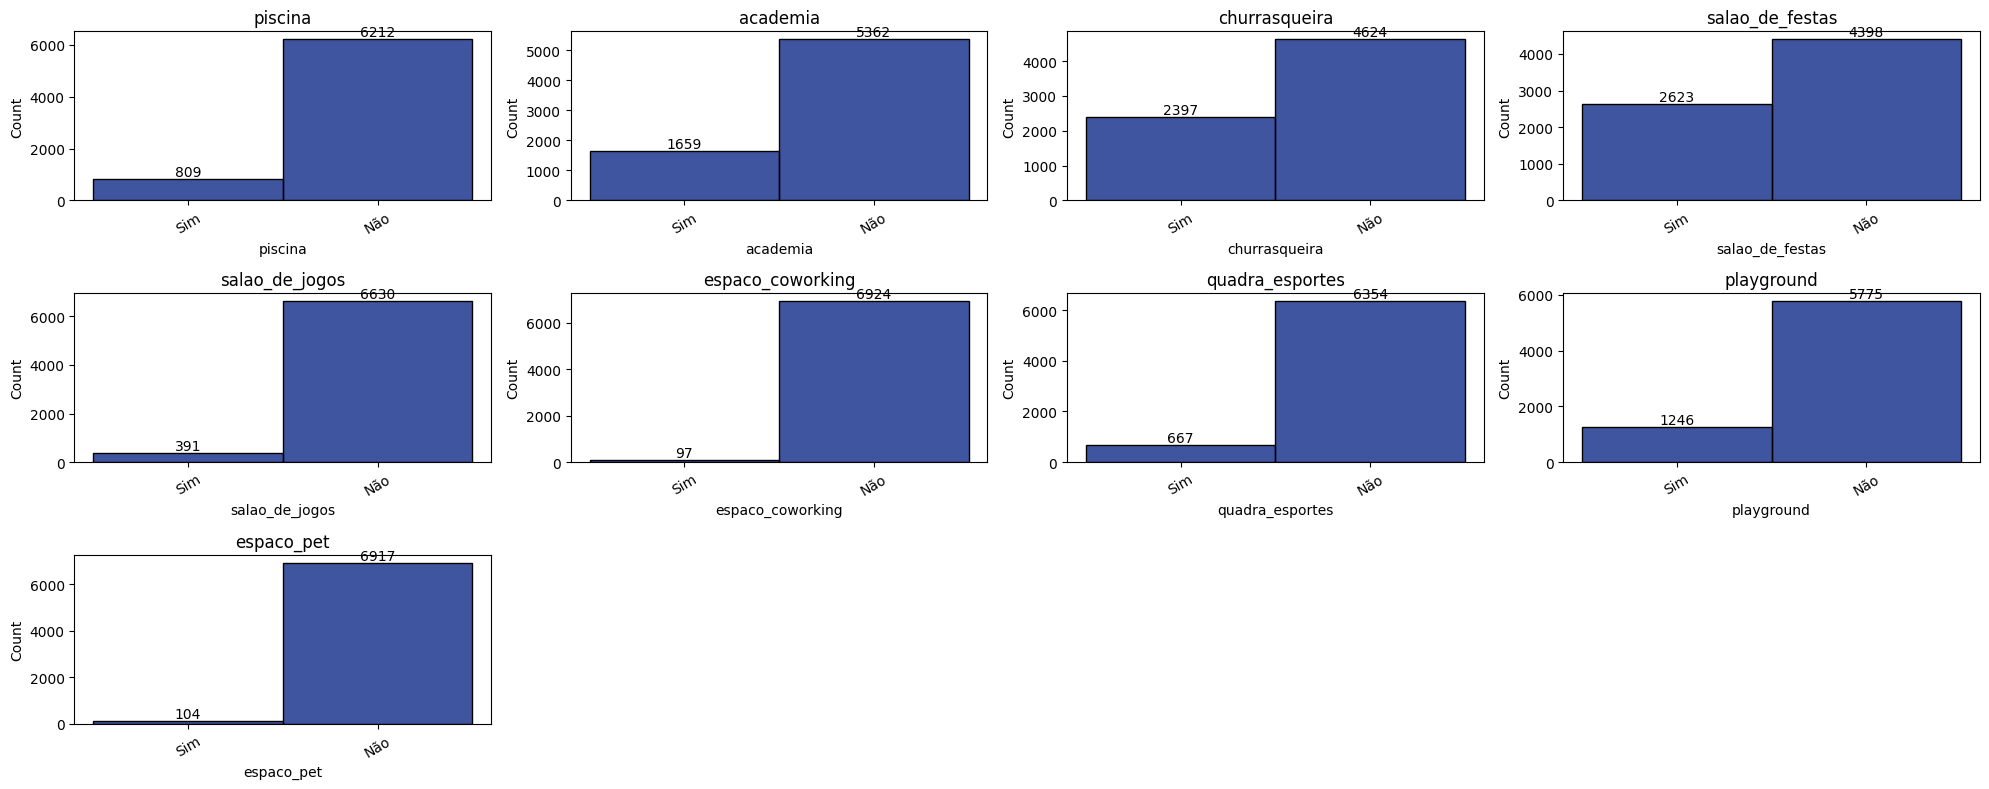

In [45]:
columns_features = [
'piscina', 
'academia', 
'churrasqueira', 
'salao_de_festas',
'salao_de_jogos',
'espaco_coworking', 
'quadra_esportes', 
'playground', 
'espaco_pet', 
]


utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    n_rows = 3, 
    n_cols = 4, 
    figsize=(20, 8), 
    plot = sns.histplot, 
    plot_kwargs={'bins':50}, 
    loop_feature = 'x' ,
    label=True,
    save_image=True,
    nome_imagem='analise_univariada_dados_condominio')

plt.tight_layout()

Gráfico salvo em: images/analise_univariada_dados_regiao.png


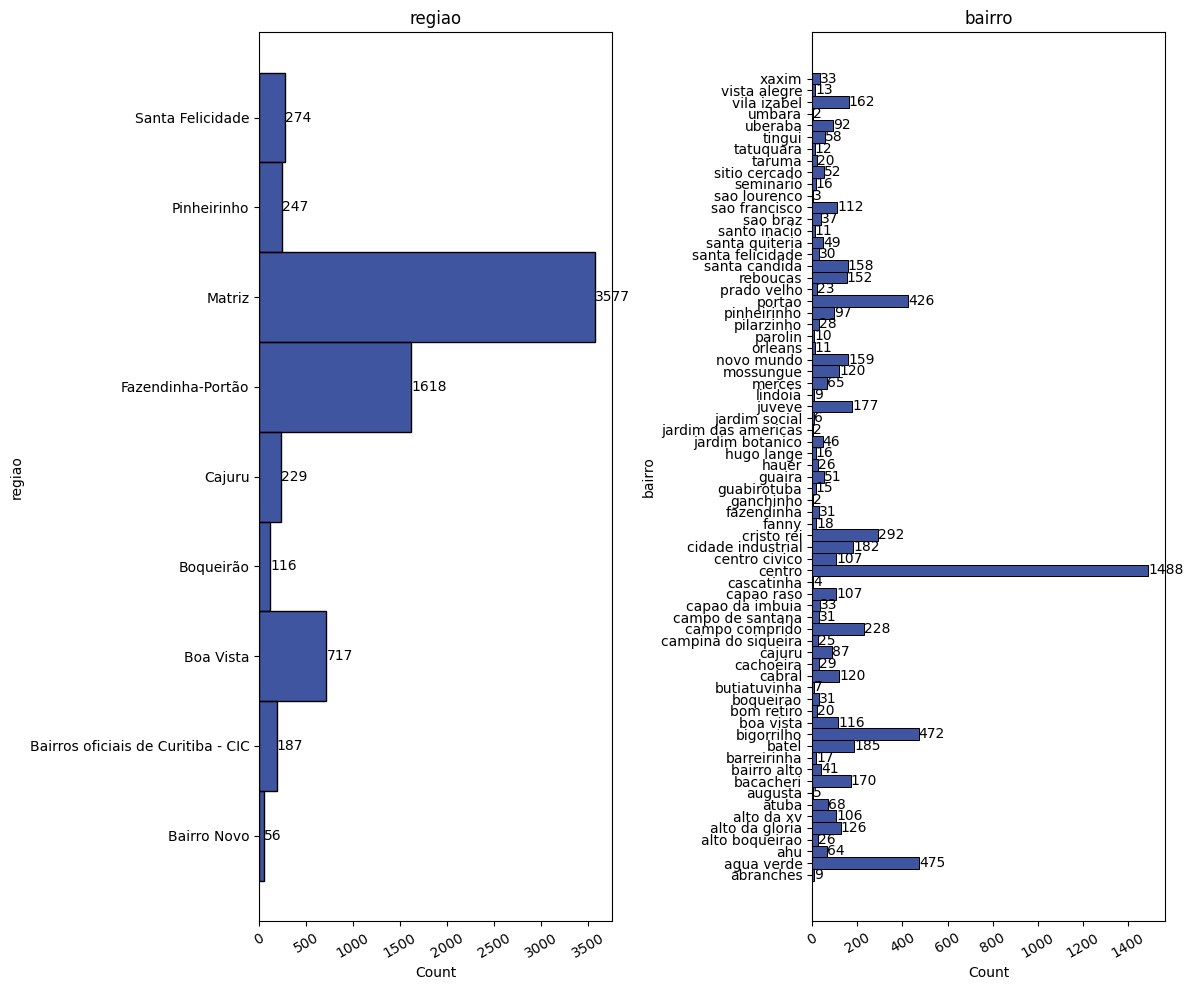

In [46]:
columns_features = ['regiao','bairro']

utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    plot = sns.histplot, 
    plot_kwargs={'bins':50}, 
    loop_feature = 'y',
    label=True,
    n_rows = 1, 
    n_cols = 2, 
    figsize=(12, 10), 
    save_image=True,
    nome_imagem='analise_univariada_dados_regiao'
)

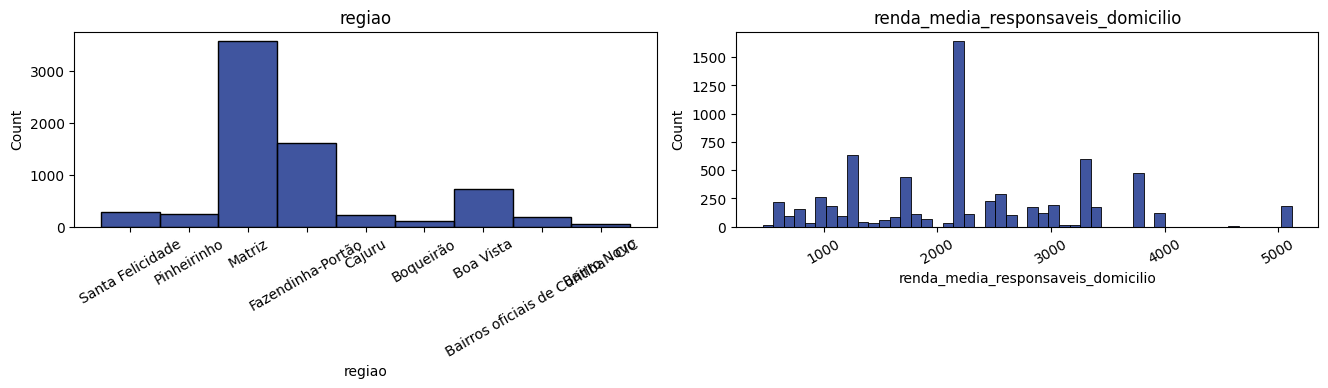

In [47]:
columns_features = ['regiao','renda_media_responsaveis_domicilio']

utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    n_rows = 10, 
    n_cols = 3, 
    figsize=(20, 35), 
    plot = sns.histplot, 
    plot_kwargs={'bins':50}, 
    loop_feature = 'x' ,
    label=False)

plt.tight_layout()

### Análise Bivariada

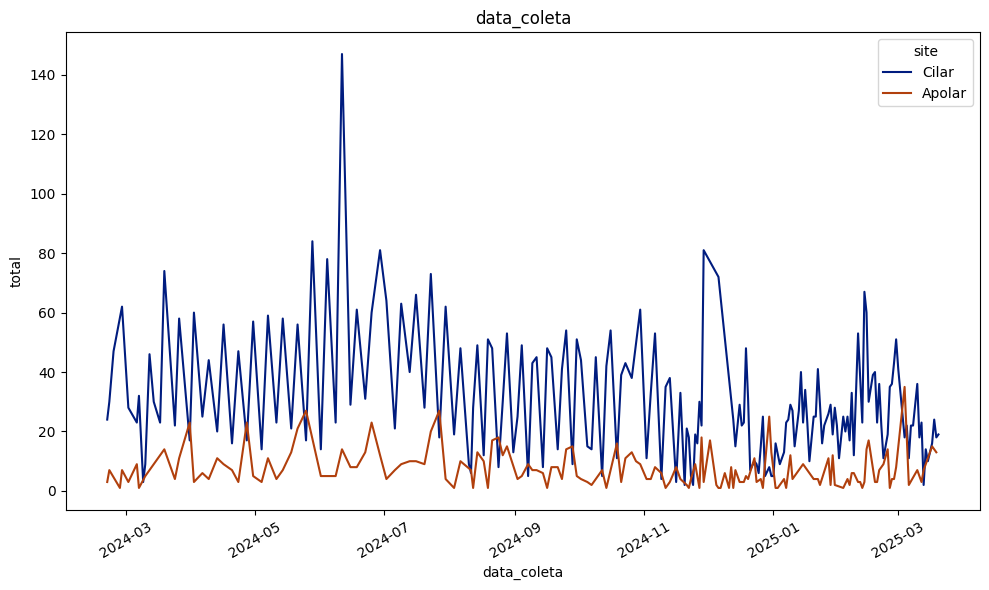

In [48]:
aux = df_exp.groupby(['data_coleta','site']).agg(total=('link','nunique')).reset_index()

utils.plot_matrix(
    data=aux, 
    columns_features=['data_coleta'], 
    plot = sns.lineplot, 
    plot_kwargs={'y':'total','hue':'site'}, 
    loop_feature = 'x',
    label=False,
    n_rows = 1, 
    n_cols = 1, 
    figsize=(10, 6)

)

Gráfico salvo em: images/analise_bivariada_numerica.png


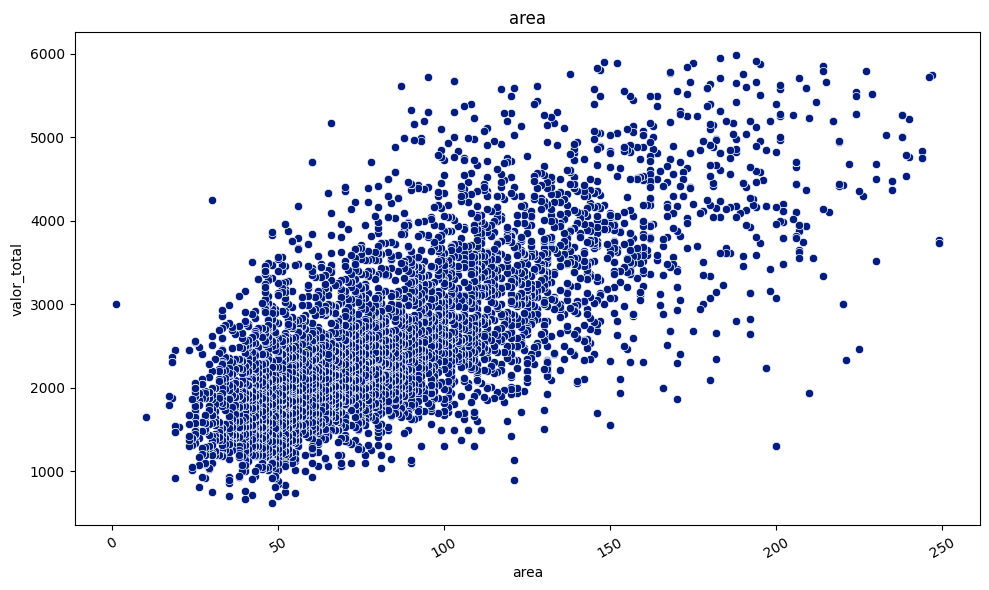

In [49]:
categorical_columns = [
    'area',
]

utils.plot_matrix(
    data=df_exp, 
    columns_features=categorical_columns, 
    plot = sns.scatterplot, 
    plot_kwargs={'y':'valor_total'}, 
    loop_feature = 'x',
    label=False,
    n_rows = 1, 
    n_cols = 1, 
    figsize=(10, 6),
    save_image=True,
    nome_imagem='analise_bivariada_numerica'
)

Gráfico salvo em: images/analise_bivariada_categorica.png


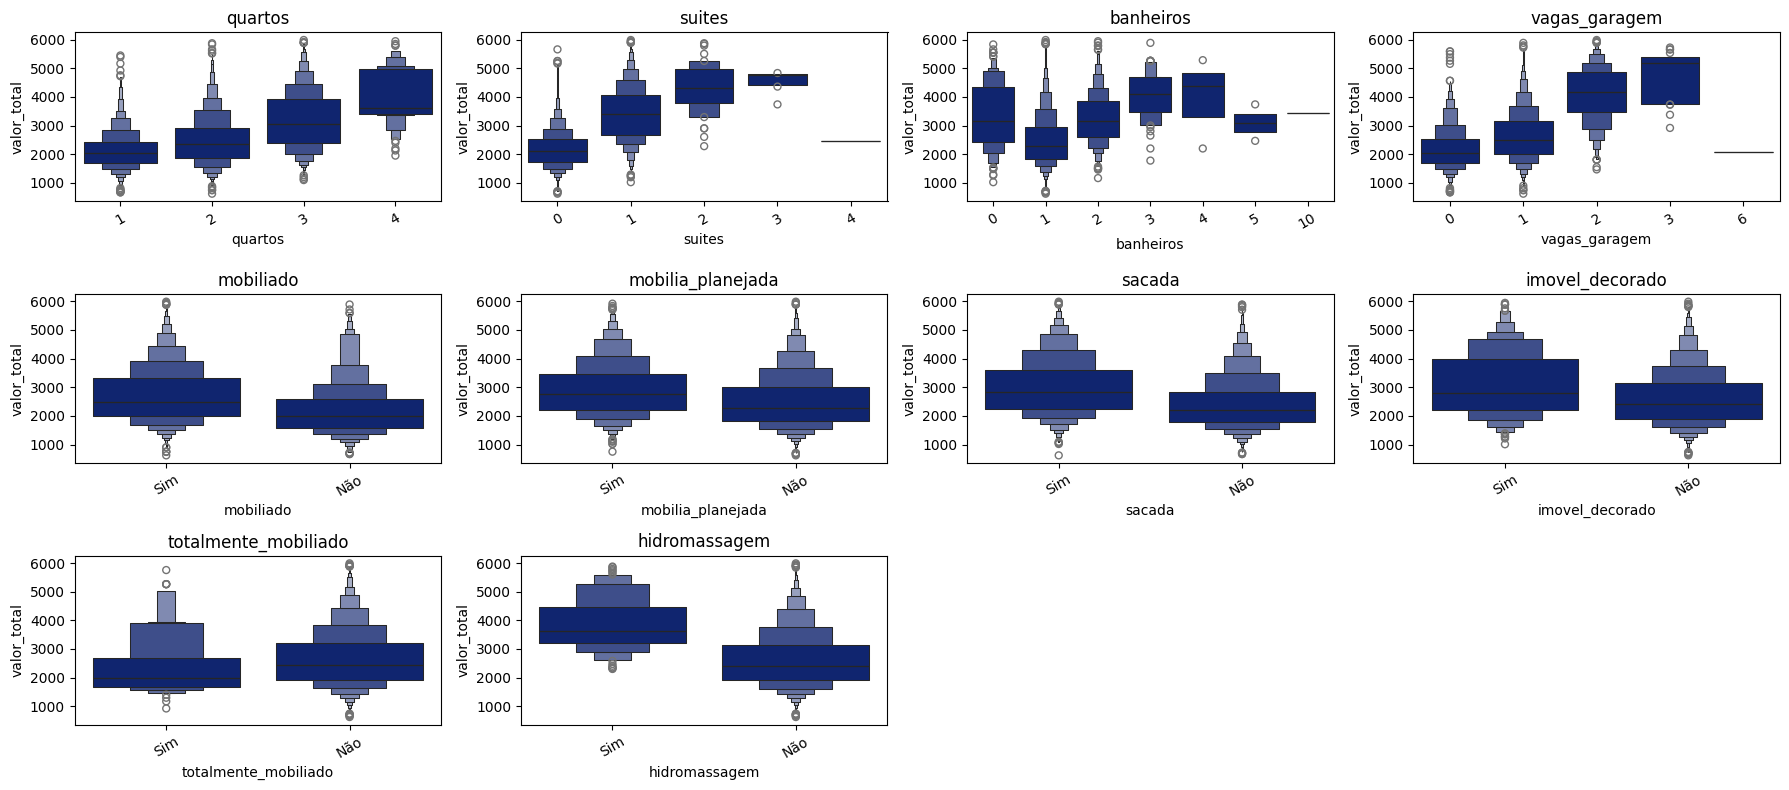

In [50]:
columns_features = ['quartos', 'suites', 'banheiros', 'vagas_garagem', 'mobiliado', 'mobilia_planejada', 'sacada', 'imovel_decorado', 'totalmente_mobiliado','hidromassagem']


utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    plot = sns.boxenplot, 
    plot_kwargs={'y':'valor_total'}, 
    loop_feature = 'x',
    label=False,
    n_rows = 3, 
    n_cols = 4, 
    figsize=(18, 8), 
    save_image=True,
    nome_imagem='analise_bivariada_categorica'
)

Gráfico salvo em: images/analise_bivariada_categorica2.png


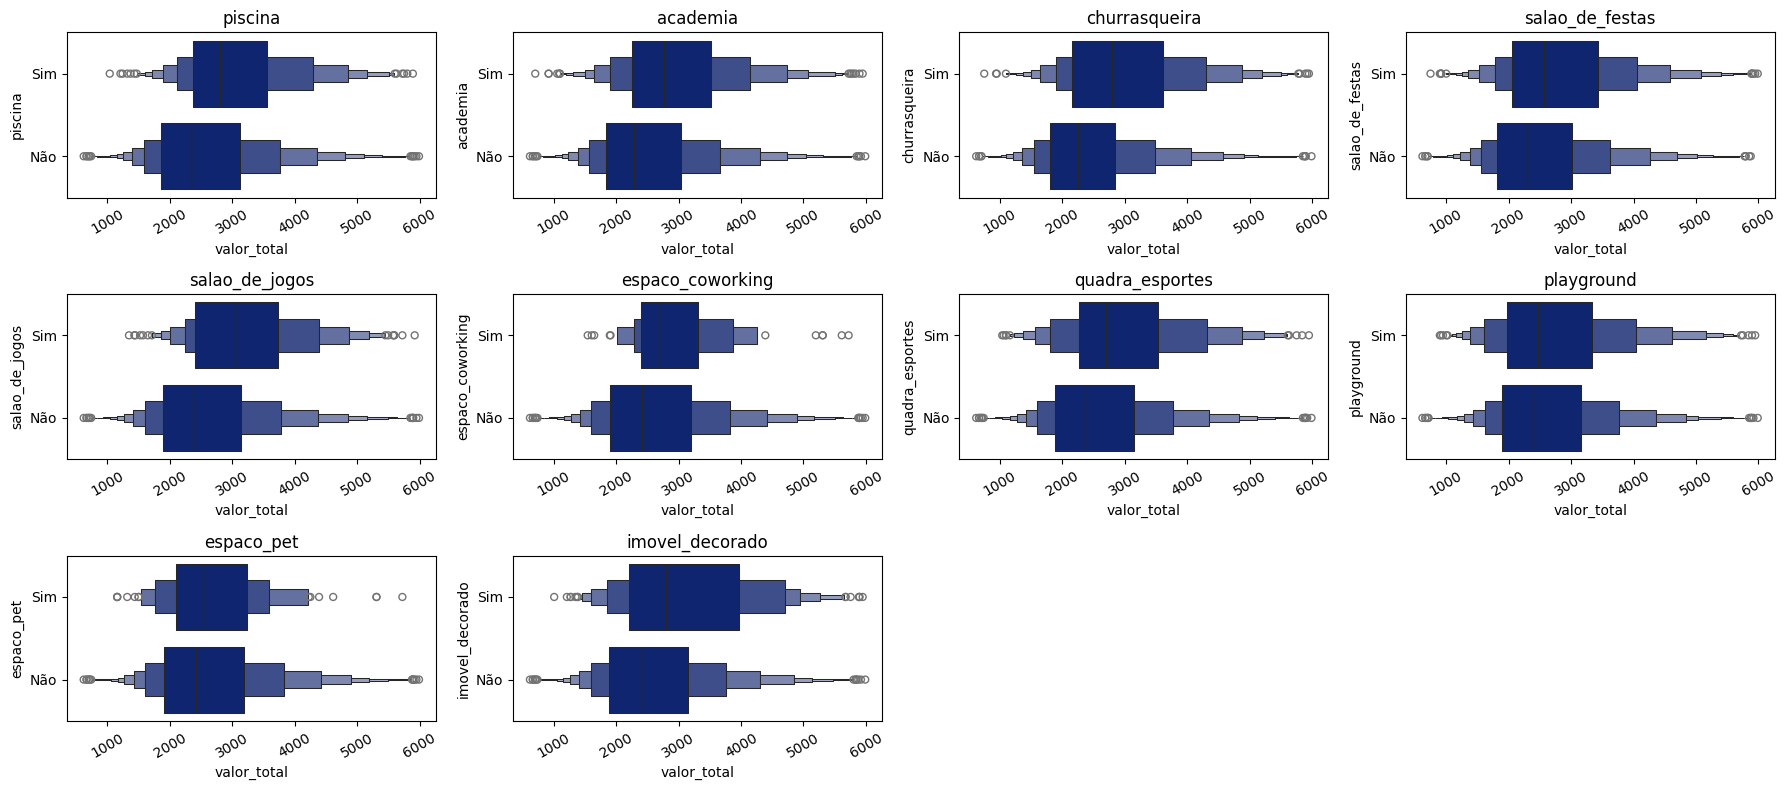

In [51]:
columns_features = [
    'piscina', 
'academia', 
'churrasqueira', 
'salao_de_festas',
'salao_de_jogos',
'espaco_coworking', 
'quadra_esportes', 
'playground', 
'espaco_pet', 
'imovel_decorado'
]

utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    plot = sns.boxenplot, 
    plot_kwargs={'x':'valor_total'}, 
    loop_feature = 'y',
    label=False,
    n_rows = 3, 
    n_cols = 4, 
    figsize=(18, 8), 
    save_image=True,
    nome_imagem='analise_bivariada_categorica2'
)

Gráfico salvo em: images/analise_bivariada_categorica3.png


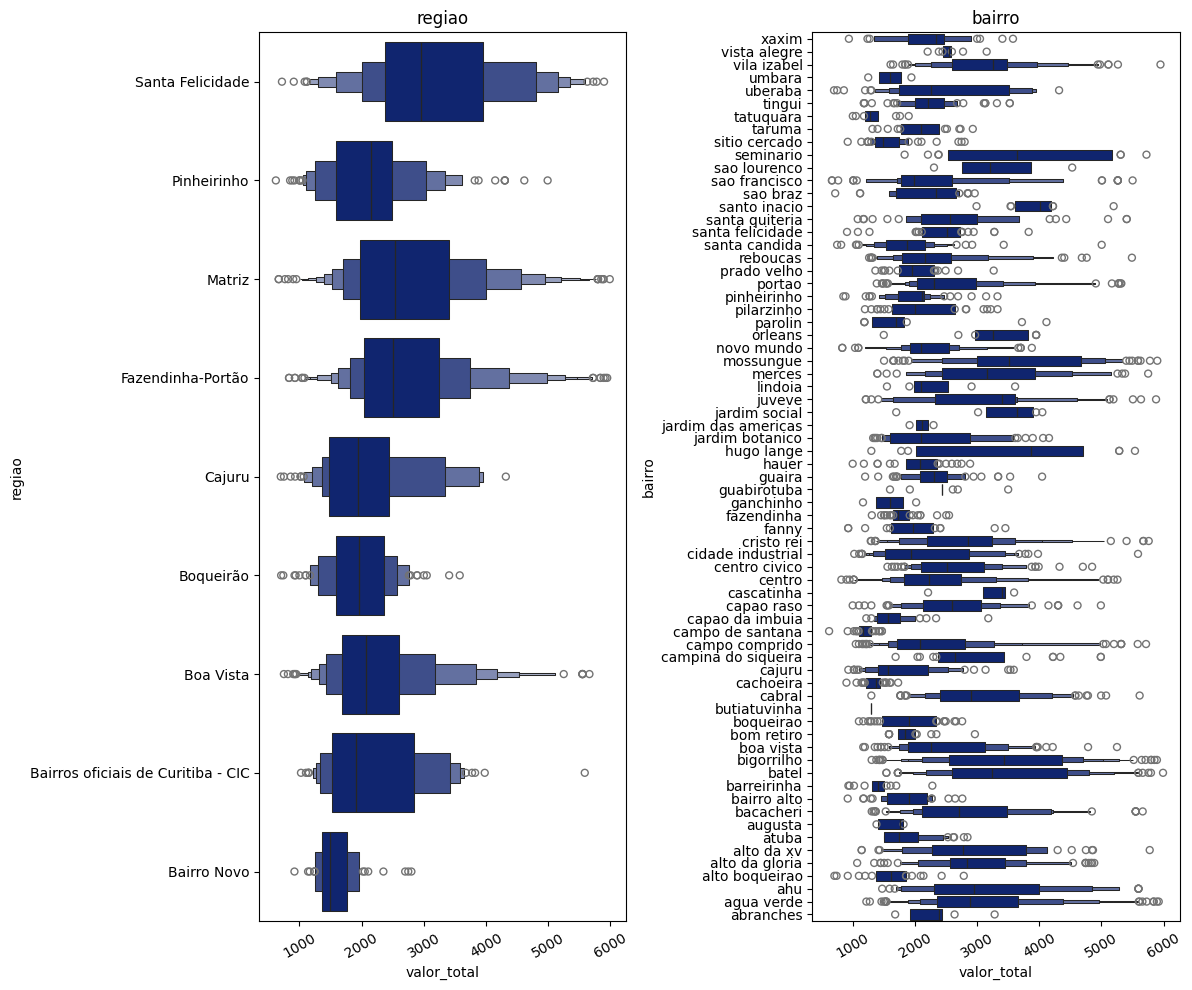

In [52]:
columns_features = ['regiao','bairro']

utils.plot_matrix(
    data=df_exp, 
    columns_features=columns_features, 
    plot = sns.boxenplot, 
    plot_kwargs={'x':'valor_total'}, 
    loop_feature = 'y',
    label=False,
    n_rows = 1, 
    n_cols = 2, 
    figsize=(12, 10), 
    save_image=True,
    nome_imagem='analise_bivariada_categorica3'
)

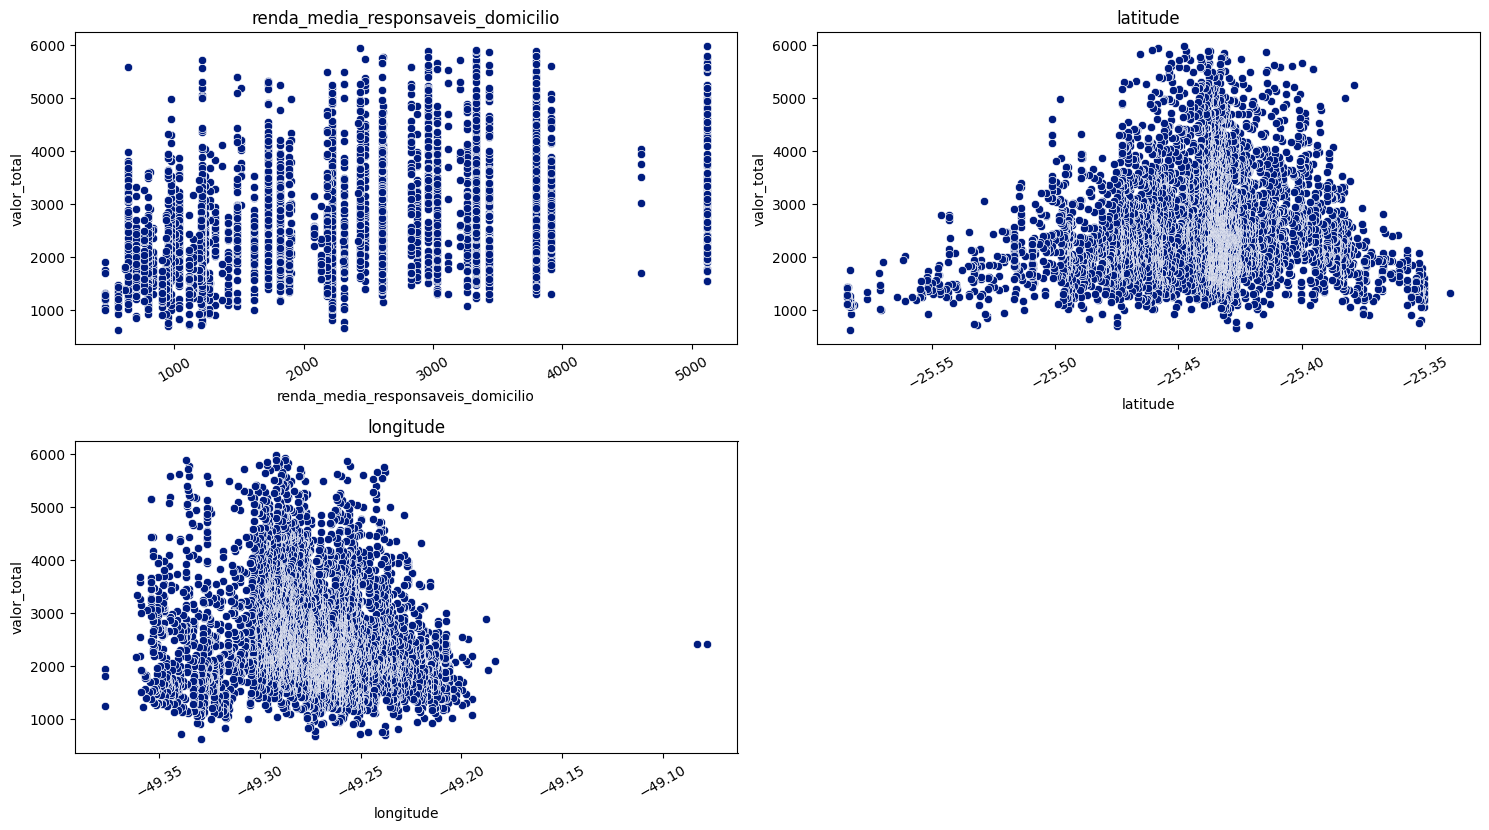

In [53]:
categorical_columns = [
    'renda_media_responsaveis_domicilio',
    'latitude',
    'longitude'
]

utils.plot_matrix(
    data=df_exp, 
    columns_features=categorical_columns, 
    plot = sns.scatterplot, 
    plot_kwargs={'y':'valor_total'}, 
    loop_feature = 'x',
    label=False,
    n_rows = 5, 
    n_cols = 2, 
    figsize=(15, 20)
)

### Análise Multivariada

In [54]:
num_cols = ['aluguel', 'condominio', 'iptu', 'area', 'quartos', 'suites',
       'banheiros', 'vagas_garagem', 'valor_total',
       'latitude', 'longitude', 'qtd_domicilios_particulares',
       'renda_media_responsaveis_domicilio'
       ]

In [55]:
dummie_columns = [
    'piscina',
    'academia', 
    'sacada',
    'churrasqueira', 
    'salao_de_festas',
    'salao_de_jogos',
    'espaco_coworking', 
    'quadra_esportes', 
    'playground', 
    'lavanderia',
    'espaco_pet', 
    'imovel_decorado',
    'totalmente_mobiliado',
    'hidromassagem'
]

aux = df_exp.copy()

aux[dummie_columns] = aux[dummie_columns].replace({'Sim':1, 'Não':0})

Gráfico salvo em: images/analise_multivariada.png


'images/analise_multivariada.png'

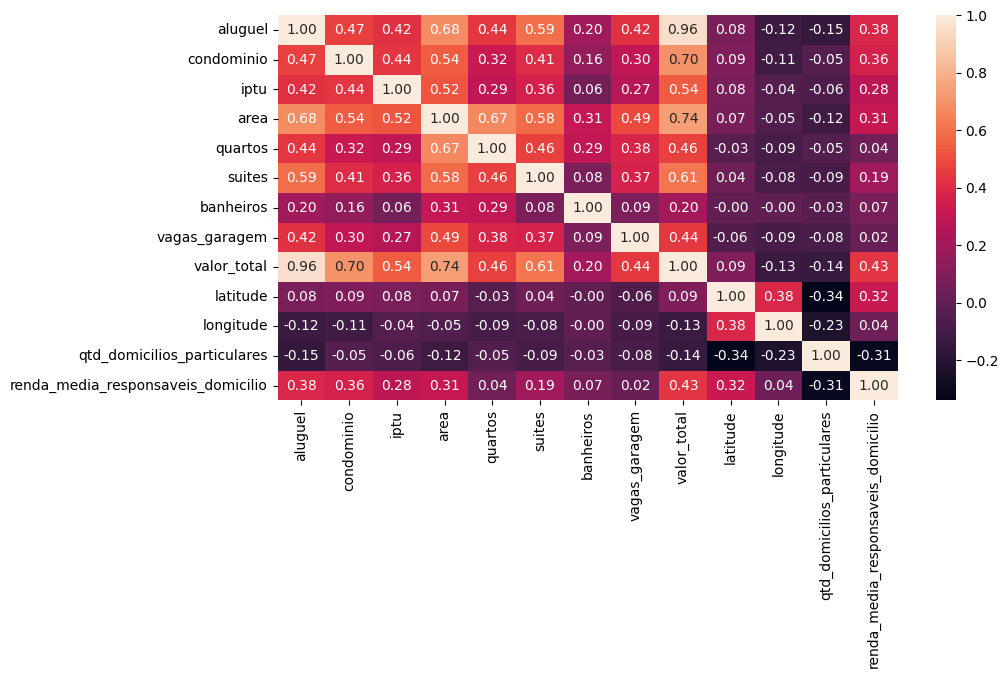

In [56]:
plt.figure(figsize=(10,5))
num_attributes = aux[num_cols]
correlations = num_attributes.corr(method='pearson', )
plt.title('',fontsize=15)
sns.heatmap(correlations,annot=True, fmt='.2f')
utils.salvar_grafico('analise_multivariada', 'images/', figura=plt.gcf(), formato='png', dpi=700)


## Preparação dos Dados

In [57]:
df_prep = df_exp.copy()
df_prep.to_pickle('params/data/df_prep.pkl')
df_prep = pd.read_pickle('params/data/df_prep.pkl')

In [58]:
all_features = [
    # 'valor_total',
    'area',
    'bairro',
    'regiao',
    'quartos',
    'suites',
    'banheiros',
    'vagas_garagem',
    'mobiliado', 
    'mobilia_planejada',

    'piscina', 
    'academia', 
    'sacada',
    'churrasqueira', 
    'salao_de_festas',
    'salao_de_jogos',
    'espaco_coworking', 
    'quadra_esportes', 
    'playground', 
    #'lavanderia',
    'espaco_pet', 
    'imovel_decorado',
    'totalmente_mobiliado',
    'hidromassagem',

    'qtd_domicilios_particulares',
    'renda_media_responsaveis_domicilio',
    
    'year_sin',
    'year_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'latitude',
    'longitude'
]

In [59]:
dict_preparation_final = {
    'area': 'standart_scaler',
    'bairro': 'target_encode',
    'regiao': 'target_encode',
    'quartos' : 'standart_scaler',
    'suites' : 'standart_scaler',
    'banheiros' : 'standart_scaler',
    'vagas_garagem' : 'standart_scaler',
    'mobiliado' :'dummie_encode',
    'mobilia_planejada' :'dummie_encode',
    'piscina' :'dummie_encode',
    'academia' :'dummie_encode',
    'sacada' :'dummie_encode',
    'churrasqueira' :'dummie_encode',
    'salao_de_festas' :'dummie_encode',
    'salao_de_jogos' :'dummie_encode',
    'espaco_coworking' :'dummie_encode',
    'quadra_esportes' :'dummie_encode',
    'playground' :'dummie_encode',
    'lavanderia' :'dummie_encode',
    'imovel_decorado' :'dummie_encode',
    'espaco_pet':'dummie_encode',
    'imovel_decorado':'dummie_encode',
    'totalmente_mobiliado':'dummie_encode',
    'hidromassagem':'dummie_encode',
    'qtd_domicilios_particulares':'robust_scaler',
    'renda_media_responsaveis_domicilio': 'robust_scaler',
    'year':'ciclycal_encode',
    'month':'ciclycal_encode',
    'day':'ciclycal_encode',
    'week_of_year':'ciclycal_encode',
    'latitude': 'standart_scaler',
    'longitude':'standart_scaler',
    #'valor_total':np.log1p
}

utils.save_picked_file(file=dict_preparation_final, name='dict_data_preparation')

In [60]:
df_transformed = utils.preparacao_dos_dados(df=df_prep, dict_preparation=dict_preparation_final, is_train=True)

## Seleção de Features

### Selecionando Features

In [61]:
# Seleção de features
selector = SelectKBest(score_func=f_classif, k=21)
selector.fit_transform(df_transformed[all_features], df_transformed['valor_total'])

# Nomes das features selecionadas
features_selected = df_transformed[all_features].columns[selector.get_support()]

utils.save_picked_file(file=features_selected, name='features_selected')

Gráfico salvo em: images/features_selecionadas.png


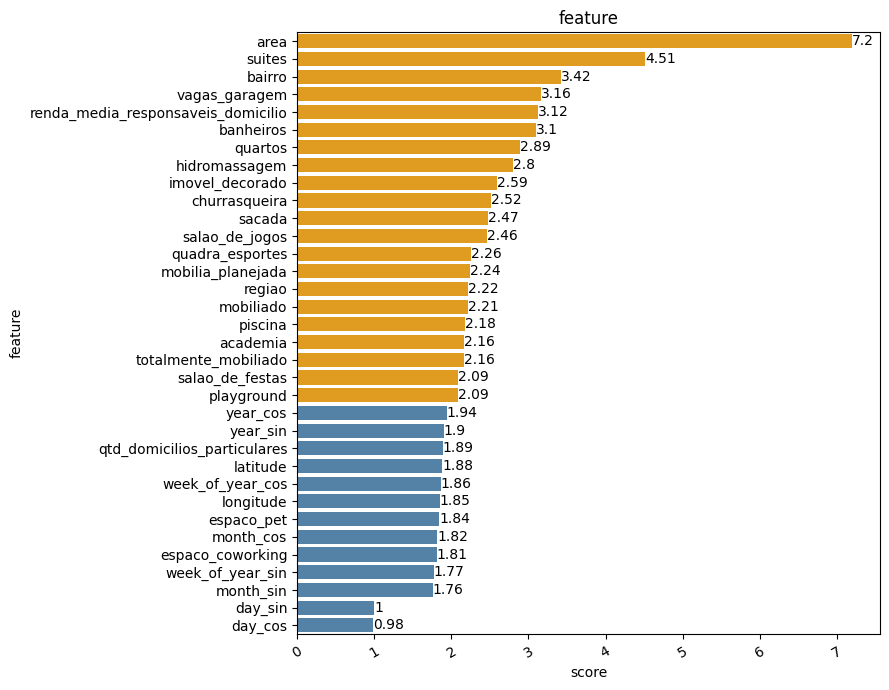

In [62]:
# Scores e p-values
scores = selector.scores_
pvalues = selector.pvalues_

# DataFrame com os resultados
resultados = pd.DataFrame({
    'feature': df_transformed[all_features].columns,
    'score': np.round(scores, 2),
    'p-value': pvalues
}).sort_values(by='score', ascending=False)

colors = ['orange' if f in features_selected else 'steelblue' for f in resultados.sort_values('score', ascending= False)['feature'].tolist() ]

utils.plot_matrix(
    data=resultados,
    columns_features=['feature'],
    plot=sns.barplot,
    loop_feature='y',
    sort_by='score',
    n_rows=1,
    n_cols=1,
    figsize=(9, 7),
    plot_kwargs={'x':'score', 'palette' :colors},
    save_image=True,
    nome_imagem='features_selecionadas'
)

### Traçando Importancia das Features

Gráfico salvo em: images/importancias_das_features.png


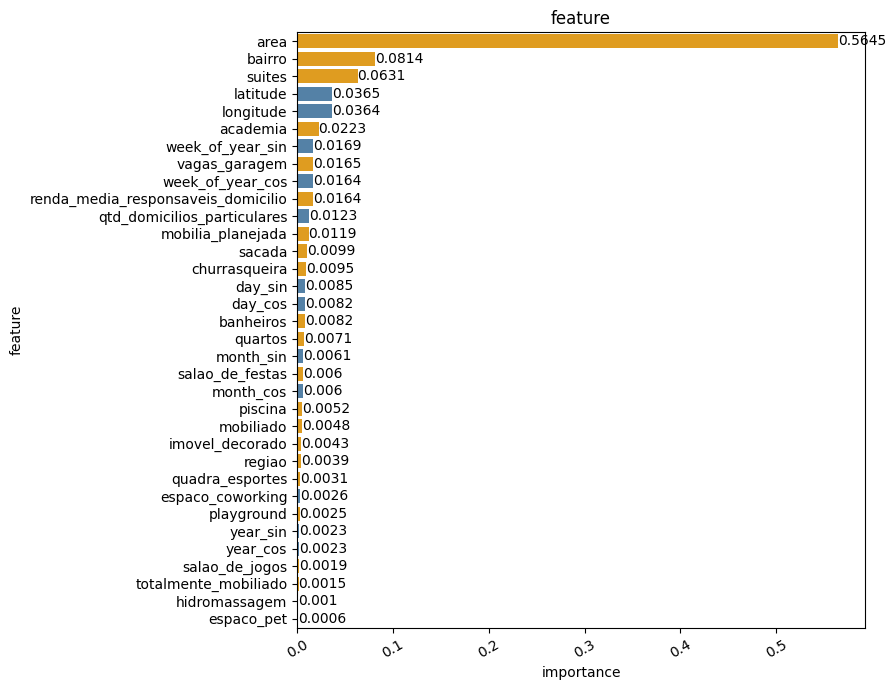

In [63]:
# Seletor de Features
model = en.RandomForestRegressor()

model.fit(df_transformed[all_features], df_transformed['valor_total'])
importances = model.feature_importances_

# Plot
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = np.asarray(all_features)


# Lista de nomes ordenados
ordered_feature_names = [feature_names[i] for i in indices]
colors = ['orange' if f in features_selected else 'steelblue' for f in ordered_feature_names]

features_importances = pd.DataFrame([feature_names[indices], importances[indices]]).T.rename(columns={0: 'feature', 1:'importance'})
features_importances['importance'] = features_importances['importance'].apply(lambda x: round(x, 4))

utils.plot_matrix(
    data=features_importances,
    columns_features=['feature'],
    plot=sns.barplot,
    loop_feature='y',
    sort_by='importance',
    n_rows=1,
    n_cols=1,
    figsize=(9, 7),
    plot_kwargs={'x':'importance', 'palette':colors},
    save_image=True,
    nome_imagem='importancias_das_features'
)

## Modelagem

In [64]:
df_ml = df_prep.copy()
df_ml.to_pickle('params/data/df_ml.pkl')
df_ml = pd.read_pickle('params/data/df_ml.pkl')

### Split Dataset

In [65]:
data_train, data_test = utils.split_dataset(
    data = df_ml,
    k = 1,
    k_fold = 1,
    len_train = df_ml.shape[0] - 700,
    len_validation = 700,
    metodo_split = 'tamanho_treino_cheio',
    verbose = True
)

K Fold 1 --------
Start Train     : 0
End Train       : 6321
Start Validation: 6321
End Validation  : 7021


### Escolhendo Melhor Modelo

#### Cross Validation

In [66]:
models = {
    'Linear Regression': lm.LinearRegression(),
    'Lasso': lm.Lasso(),
    'Random Forest': en.RandomForestRegressor(n_jobs=-1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_jobs = -1 ,random_state = 42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=4)
}

results_cv = utils.cross_validation(
    data=data_train, 
    dict_models=models, 
    k_fold=5, 
    len_train = 1000 , # não preciso fixar aqui
    len_validation = 500, 
    metodo_split='tamanho_treino_cheio',
    dict_preparation= dict_preparation_final, 
    features_selected=all_features,
    verbose = True
    )



Model: Linear Regression
K Fold 1 --------
Start Train     : 0
End Train       : 1000
Start Validation: 1000
End Validation  : 1500
MAE: 432.82, MAPE: 0.19, RMSE: 544.03
-----------
K Fold 2 --------
Start Train     : 0
End Train       : 2205
Start Validation: 2205
End Validation  : 2705
MAE: 373.38, MAPE: 0.16, RMSE: 489.05
-----------
K Fold 3 --------
Start Train     : 0
End Train       : 3410
Start Validation: 3410
End Validation  : 3910
MAE: 378.99, MAPE: 0.15, RMSE: 546.93
-----------
K Fold 4 --------
Start Train     : 0
End Train       : 4615
Start Validation: 4615
End Validation  : 5115
MAE: 373.85, MAPE: 0.15, RMSE: 516.27
-----------
K Fold 5 --------
Start Train     : 0
End Train       : 5820
Start Validation: 5820
End Validation  : 6320
MAE: 405.97, MAPE: 0.15, RMSE: 554.39
-----------

Model: Lasso
K Fold 1 --------
Start Train     : 0
End Train       : 1000
Start Validation: 1000
End Validation  : 1500
MAE: 411.93, MAPE: 0.18, RMSE: 525.6
-----------
K Fold 2 --------
S

Gráfico salvo em: images/K_Folds_MAE_modelos.png


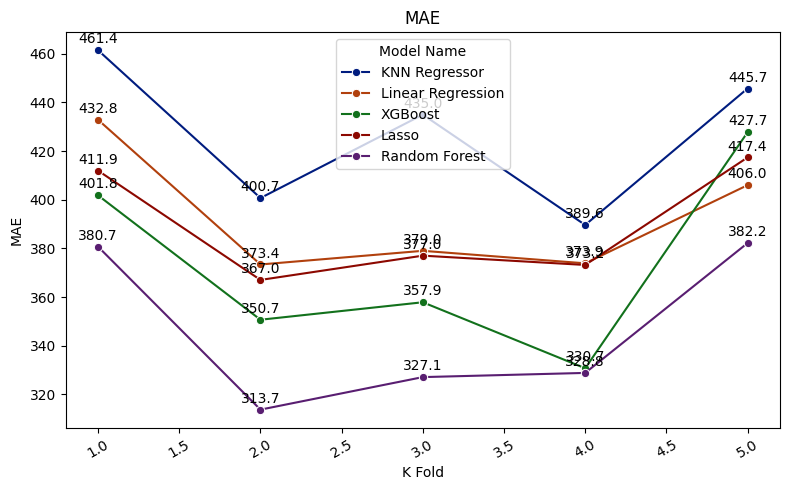

In [67]:
utils.plot_matrix(
    data=results_cv,
    columns_features=['MAE'],
    plot=sns.lineplot,
    loop_feature='y',
    plot_kwargs={'x': 'K Fold', 'hue':'Model Name', 'marker':'o'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 5),
    label=True,
    save_image=True,
    nome_imagem='K_Folds_MAE_modelos'
)

Gráfico salvo em: images/MAE_modelos.png


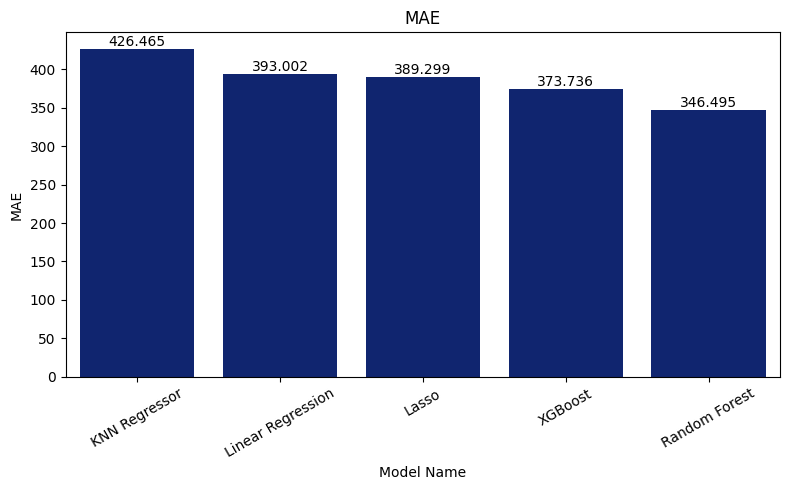

In [68]:
results_cv_por_modelo = results_cv.groupby(['Model Name']).agg( MAE = ('MAE','mean'), MAE_std = ('MAE','std'), MAPE = ('MAPE','mean'), MAPE_std = ('MAPE','std'), RMSE = ('RMSE','mean'), RMSE_std = ('RMSE','std')).reset_index()

utils.plot_matrix(
    data=results_cv_por_modelo,
    columns_features=['MAE'],
    plot=sns.barplot,
    loop_feature='y',
    plot_kwargs={'x':'Model Name'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 5),
    label=True,
    save_image=True,
    nome_imagem='MAE_modelos'
)

In [69]:
best_model_name = 'Random Forest'

#### Otimização de Janela de Treino

In [70]:
results_otimizacao_janela = pd.DataFrame()

for len_train in np.arange(1000, 5500, 250).tolist():

    df_aux = utils.cross_validation(
        data=data_train, 
        dict_models={best_model_name: models[best_model_name]}, 
        k_fold=5, 
        len_train = len_train ,
        len_validation = 500, 
        dict_preparation= dict_preparation_final, 
        features_selected=all_features,
        metodo_split = 'tamanho_treino_fixo',
        verbose = True
        )
    
    df_aux['Lenght Data Train'] = len_train

    results_otimizacao_janela = pd.concat([results_otimizacao_janela, df_aux], axis = 0)


Model: Random Forest
K Fold 1 --------
Start Train     : 0
End Train       : 1000
Start Validation: 1000
End Validation  : 1500
MAE: 380.67, MAPE: 0.17, RMSE: 500.45
-----------
K Fold 2 --------
Start Train     : 1205
End Train       : 2205
Start Validation: 2205
End Validation  : 2705
MAE: 351.42, MAPE: 0.15, RMSE: 486.37
-----------
K Fold 3 --------
Start Train     : 2410
End Train       : 3410
Start Validation: 3410
End Validation  : 3910
MAE: 364.41, MAPE: 0.14, RMSE: 525.98
-----------
K Fold 4 --------
Start Train     : 3615
End Train       : 4615
Start Validation: 4615
End Validation  : 5115
MAE: 356.21, MAPE: 0.14, RMSE: 493.73
-----------
K Fold 5 --------
Start Train     : 4820
End Train       : 5820
Start Validation: 5820
End Validation  : 6320
MAE: 400.82, MAPE: 0.14, RMSE: 565.25
-----------

Model: Random Forest
K Fold 1 --------
Start Train     : 0
End Train       : 1250
Start Validation: 1250
End Validation  : 1750
MAE: 392.98, MAPE: 0.16, RMSE: 515.66
-----------
K 

Gráfico salvo em: images/MAE_janelas_de_treino.png


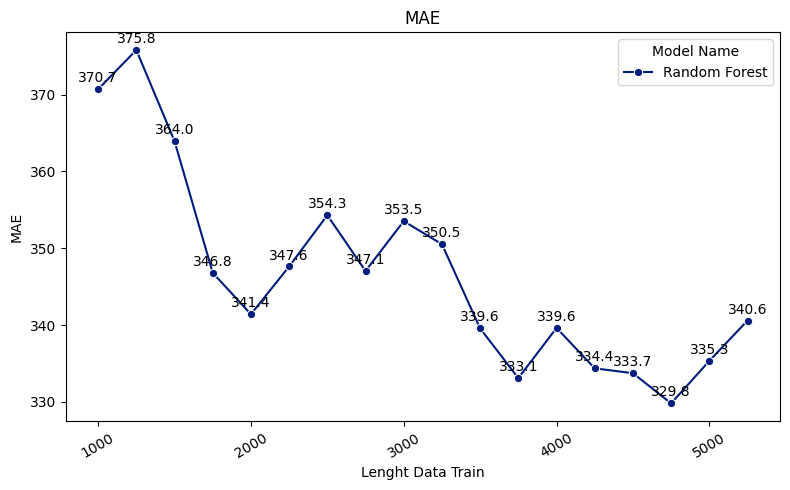

In [71]:
results_otimizacao_janela_resumo = results_otimizacao_janela.groupby(['Lenght Data Train','Model Name']).agg( MAE = ('MAE','mean'), MAE_std = ('MAE','std'), MAPE = ('MAPE','mean'), MAPE_std = ('MAPE','std'), RMSE = ('RMSE','mean'), RMSE_std = ('RMSE','std')).reset_index()

utils.plot_matrix(
    data=results_otimizacao_janela_resumo,
    columns_features=['MAE'],
    plot=sns.lineplot,
    loop_feature='y',
    plot_kwargs={'x': 'Lenght Data Train', 'hue':'Model Name', 'marker':'o'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 5),
    label=True,
    save_image=True,
    nome_imagem='MAE_janelas_de_treino'
)

## Tunagem dos Hiperparâmetros

In [73]:
data_train.columns

Index(['site', 'data_coleta', 'titulo', 'link', 'endereco', 'cidade', 'bairro',
       'aluguel', 'condominio', 'iptu', 'area', 'quartos', 'suites',
       'banheiros', 'vagas_garagem', 'mobiliado', 'mobilia_planejada',
       'piscina', 'academia', 'sacada', 'churrasqueira', 'salao_de_festas',
       'salao_de_jogos', 'espaco_coworking', 'quadra_esportes', 'playground',
       'lavanderia', 'espaco_pet', 'imovel_decorado', 'totalmente_mobiliado',
       'hidromassagem', 'valor_total', 'year', 'month', 'day', 'week_of_year',
       'latitude', 'longitude', 'regiao', 'area_bairro', 'qtd_homens',
       'qtd_mulheres', 'total', 'qtd_domicilios_particulares',
       'renda_media_responsaveis_domicilio'],
      dtype='object')

In [109]:
from sklearn.model_selection import RandomizedSearchCV

n_iter=50
cv=5
random_state=42
scoring='neg_mean_absolute_error'

param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=n_iter,
    cv=cv,
    verbose=1,
    random_state=random_state,
    scoring=scoring,
    n_jobs=-1
)

data_train_transformed = utils.preparacao_dos_dados(df=data_train, dict_preparation=dict_preparation_final, is_train=True)

random_search.fit(data_train_transformed[all_features], data_train_transformed['valor_total'])
best_model = random_search.best_estimator_
best_params = random_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [119]:
random_search.cv_results_['mean_test_score']

array([          nan, -361.12521018,           nan, -341.69711783,
       -348.65916537, -360.92959894, -333.07635379, -356.83685504,
                 nan, -430.22910717, -360.25515349, -430.73662114,
       -430.33408629, -370.95836433,           nan,           nan,
       -360.12551195, -430.58643327, -372.35197847, -343.99331188,
                 nan, -430.98300835,           nan, -360.16491905,
                 nan,           nan,           nan, -350.57808412,
       -342.29785904, -366.4061417 , -430.09364282, -350.73796946,
                 nan,           nan,           nan,           nan,
                 nan, -429.36064672, -350.98087395, -351.71760178,
       -355.8163073 ,           nan,           nan, -350.96254061,
       -338.60460087, -350.13849796,           nan, -339.6316195 ,
       -348.98371929, -432.49478151])

In [121]:
best_model

RandomForestRegressor(bootstrap=False, max_features='log2',
                      n_estimators=np.int64(800))

In [122]:
best_params

{'n_estimators': np.int64(800),
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': False}

## Avaliando Modelo

#### Aplicando dados de treino no Modelo - Todas as Features

In [123]:
# definições
optimal_len_train = 4750

# treinando modelo
y_real, y_pred, _ = utils.prepare_fit_and_predict(
    model = best_model, 
    data_train = data_train.tail(optimal_len_train), 
    data_validation = data_train.tail(optimal_len_train), 
    dict_preparation = dict_preparation_final, 
    features_selected = all_features, 
    log_on=False
    )

# adicionando predição no dataset
data_train_replic = data_train.tail(optimal_len_train).copy()
data_train_replic['prediction'] = y_pred
data_train_replic['error'] = data_train_replic['valor_total'] - data_train_replic['prediction']

utils.ml_error('Random Forest', y_real, y_pred).round(2)

,Model Name,MAE,MAPE,RMSE
0,Random Forest,0.7,0.0,9.44


Gráfico salvo em: images/Treino - Erro v Valor total (all_features).png


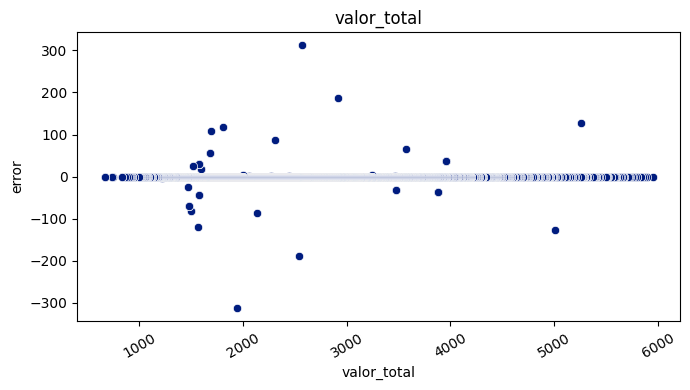

In [124]:
utils.plot_matrix(
    data=data_train_replic,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    save_image=True,
    nome_imagem='Treino - Erro v Valor total (all_features)'
)

Gráfico salvo em: images/Treino - Histograma de Erros (all_features).png
Média dos Erros: 0.0


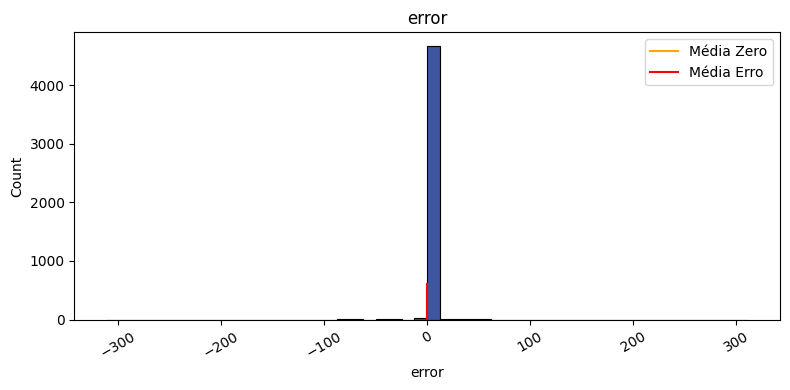

In [127]:
utils.plot_matrix(
    data=data_train_replic,
    columns_features=['error'],
    plot=sns.histplot,
    loop_feature='x',
    plot_kwargs={'bins': 50},
    n_cols=1,
    n_rows=1,
    figsize=(8, 4) ,
    label = False
)

sns.lineplot(x = np.arange(0,0.0001, 0.0001/600), y=np.arange(600), color='orange', label = 'Média Zero')
sns.lineplot(x = np.arange(data_train_replic['error'].mean(),data_train_replic['error'].mean()+0.0001, 0.0001/600), y=np.arange(600), color='red', label='Média Erro')
plt.legend()

utils.salvar_grafico(dpi=700, formato='png', nome_arquivo='Treino - Histograma de Erros (all_features)', pasta_destino='images')

media_erros = np.round(np.float64(data_train_replic['error'].mean()), 2)
print(f'Média dos Erros: {media_erros}')

#### Aplicando dados de teste no Modelo - Todas as Features

In [128]:
y_real, y_pred, _ = utils.prepare_fit_and_predict(
    model = best_model, 
    data_train = data_train.tail(optimal_len_train), 
    data_validation = data_test,
    dict_preparation = dict_preparation_final, 
    features_selected = all_features, 
    log_on=False
    )

data_test['prediction'] = y_pred
data_test['error'] = data_test['valor_total'] - data_test['prediction']

utils.ml_error('Random Forest', y_real, y_pred).round(2)

,Model Name,MAE,MAPE,RMSE
0,Random Forest,270.22,0.11,404.28


Gráfico salvo em: images/Teste - Erro v Valor total (all_features).png


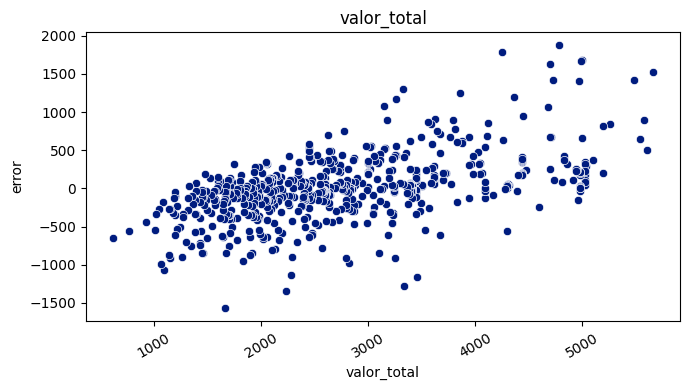

In [129]:
utils.plot_matrix(
    data=data_test,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    save_image=True,
    nome_imagem='Teste - Erro v Valor total (all_features)'
)


Gráfico salvo em: images/Teste - Histograma de Erros (all_features).png
Média dos Erros: 10.17


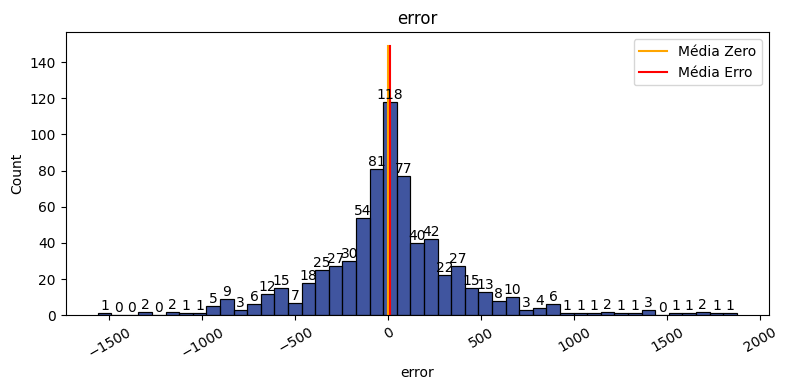

In [131]:
utils.plot_matrix(
    data=data_test,
    columns_features=['error'],
    plot=sns.histplot,
    loop_feature='x',
    # plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 4)
)

sns.lineplot(x = np.arange(0,0.0001, 0.0001/150), y=np.arange(150), color='orange', label = 'Média Zero')
sns.lineplot(x = np.arange(data_test['error'].mean(),data_test['error'].mean()+0.0001, 0.0001/150), y=np.arange(150), color='red', label = 'Média Erro')

utils.salvar_grafico(dpi=700, formato='png', nome_arquivo='Teste - Histograma de Erros (all_features)', pasta_destino='images')

media_erros = np.round(np.float64(data_test['error'].mean()), 2)
print(f'Média dos Erros: {media_erros}')


### Avaliando Modelo

In [ ]:
# treinando modelo
y_real, y_pred, _ = utils.prepare_fit_and_predict(
    model = best_model, 
    data_train = data_train.tail(optimal_len_train), 
    data_validation = data_train.tail(optimal_len_train), 
    dict_preparation = dict_preparation_final, 
    features_selected = features_selected, 
    log_on=False
    )

# adicionando predição no dataset
data_train_replic = data_train.tail(optimal_len_train).copy()
data_train_replic['prediction'] = y_pred
data_train_replic['error'] = data_train_replic['valor_total'] - data_train_replic['prediction']

utils.ml_error('Random Forest', y_real, y_pred).round(2)


,Model Name,MAE,MAPE,RMSE
0,Random Forest,28.33,0.01,91.61


Gráfico salvo em: images/Features Selected - Erro v Valor total (treino).png


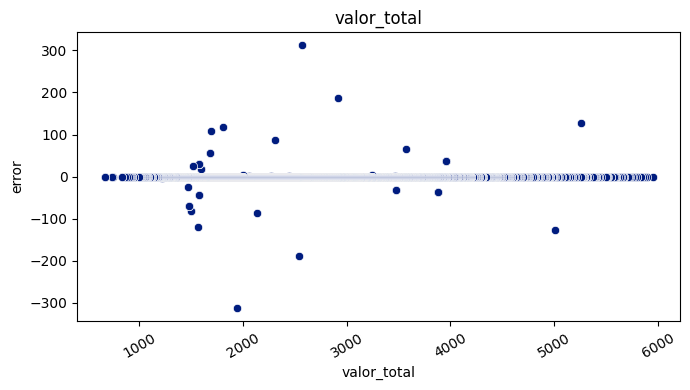

In [132]:
utils.plot_matrix(
    data=data_train_replic,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    save_image=True,
    nome_imagem='Features Selected - Erro v Valor total (treino)'
)

Gráfico salvo em: images/Features Selected - Histograma de Erros (treino).png
Média dos Erros: 0.0


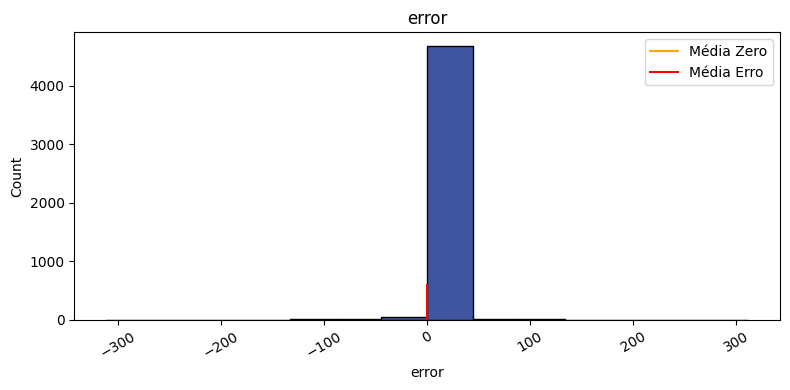

In [133]:
utils.plot_matrix(
    data=data_train_replic,
    columns_features=['error'],
    plot=sns.histplot,
    loop_feature='x',
    # plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 4) ,
    label = False
)

sns.lineplot(x = np.arange(0,0.0001, 0.0001/600), y=np.arange(600), color='orange', label = 'Média Zero')
sns.lineplot(x = np.arange(data_train_replic['error'].mean(),data_train_replic['error'].mean()+0.0001, 0.0001/600), y=np.arange(600), color='red', label='Média Erro')
plt.legend()

utils.salvar_grafico(dpi=700, formato='png', nome_arquivo='Features Selected - Histograma de Erros (treino)', pasta_destino='images')

media_erros = np.round(np.float64(data_train_replic['error'].mean()), 2)
print(f'Média dos Erros: {media_erros}')

#### Aplicando dados de teste

In [152]:
y_real, y_pred, _ = utils.prepare_fit_and_predict(
    model = best_model, 
    data_train = data_train.tail(optimal_len_train), 
    data_validation = data_test,
    dict_preparation = dict_preparation_final, 
    features_selected = features_selected, 
    log_on=False
)

data_test['prediction'] = y_pred
data_test['error'] = data_test['valor_total'] - data_test['prediction']

utils.save_picked_file(file=best_model, name='preparation/best_model')
utils.ml_error('Random Forest', y_real, y_pred).round(2)

,Model Name,MAE,MAPE,RMSE
0,Random Forest,242.08,0.1,394.6


Gráfico salvo em: images/Features Selected - Erro v Valor total (teste).png


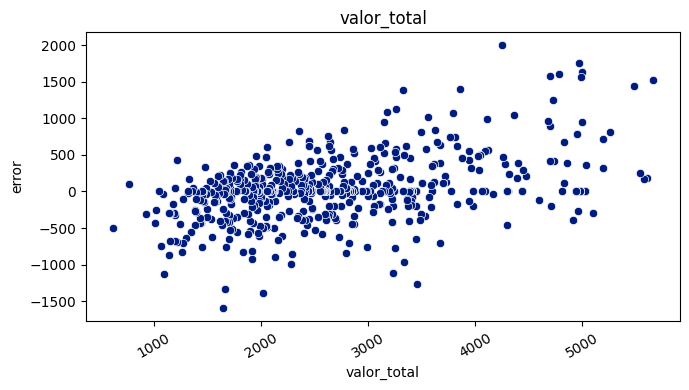

In [136]:
utils.plot_matrix(
    data=data_test,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    save_image=True,
    nome_imagem='Features Selected - Erro v Valor total (teste)'
)

Gráfico salvo em: images/Features Selected - Histograma de Erros (teste).png
Média dos Erros: 28.81


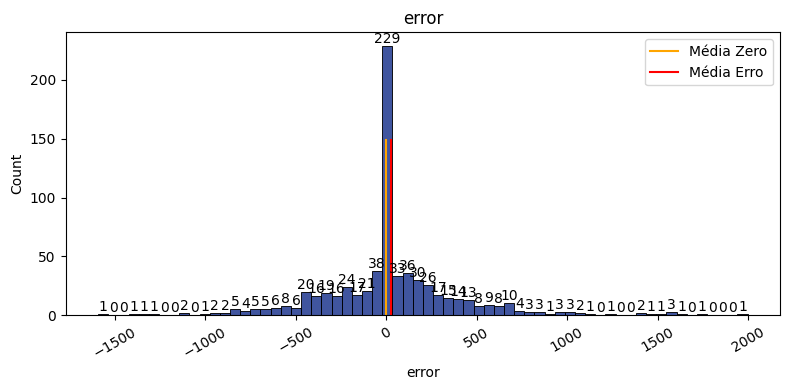

In [138]:
utils.plot_matrix(
    data=data_test,
    columns_features=['error'],
    plot=sns.histplot,
    loop_feature='x',
    # plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 4)
)

sns.lineplot(x = np.arange(0,0.0001, 0.0001/150), y=np.arange(150), color='orange', label = 'Média Zero')
sns.lineplot(x = np.arange(data_test['error'].mean(),data_test['error'].mean()+0.0001, 0.0001/150), y=np.arange(150), color='red', label = 'Média Erro')

utils.salvar_grafico(dpi=700, formato='png', nome_arquivo='Features Selected - Histograma de Erros (teste)', pasta_destino='images')

media_erros = np.round(np.float64(data_test['error'].mean()), 2)
print(f'Média dos Erros: {media_erros}')


## Baseline para o modelo

In [139]:
data_train_baseline = data_train.tail(optimal_len_train).copy()
data_test_baseline = data_test.copy()

In [140]:
data_train_baseline['valor_total_medio_m2'] = data_train_baseline['valor_total'] / data_train_baseline['area']
valor_total_por_m2_e_bairro = data_train_baseline.groupby(['bairro']).agg(valor_medio_m2_por_bairro=('valor_total_medio_m2','mean')).reset_index()

In [141]:
data_test_baseline_fited = pd.merge(data_test_baseline, valor_total_por_m2_e_bairro, on = 'bairro', how='left')
data_test_baseline_fited["prediction"] = data_test_baseline_fited['valor_medio_m2_por_bairro'] * data_test_baseline_fited['area']
data_test_baseline_fited['error'] = data_test_baseline_fited['valor_total'] - data_test_baseline_fited['prediction']

y_real = data_test_baseline_fited['valor_total'].values
y_pred = data_test_baseline_fited['prediction'].values

utils.ml_error('Random Forest', y_real, y_pred).round(2)

,Model Name,MAE,MAPE,RMSE
0,Random Forest,711.84,0.26,962.05


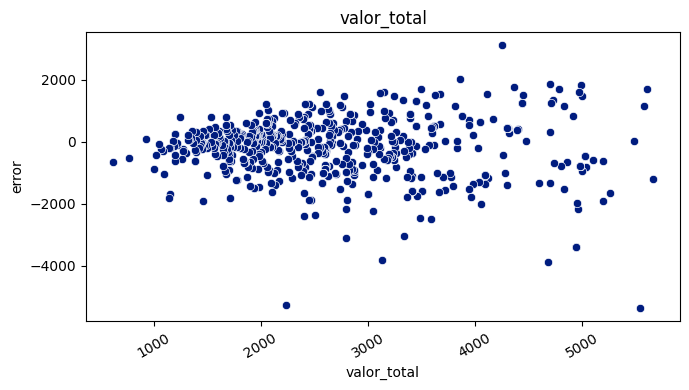

In [142]:
utils.plot_matrix(
    data=data_test_baseline_fited,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4)
)

Média dos Erros: -164.97


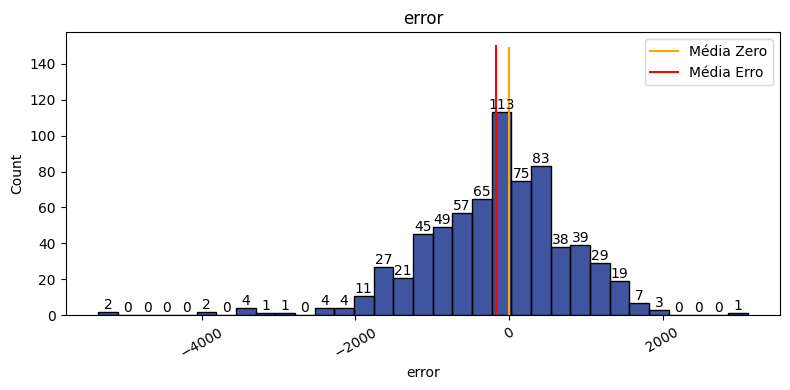

In [143]:
utils.plot_matrix(
    data=data_test_baseline_fited,
    columns_features=['error'],
    plot=sns.histplot,
    loop_feature='x',
    # plot_kwargs={'y': 'error'},
    n_cols=1,
    n_rows=1,
    figsize=(8, 4)
)

sns.lineplot(x = np.arange(0,0.0001, 0.0001/150), y=np.arange(150), color='orange', label = 'Média Zero')
sns.lineplot(x = np.arange(data_test_baseline_fited['error'].mean(),data_test_baseline_fited['error'].mean()+0.0001, 0.0001/150), y=np.arange(151), color='red', label = 'Média Erro')

media_erros = np.round(np.float64(data_test_baseline_fited['error'].mean()), 2)
print(f'Média dos Erros: {media_erros}')

### Comparação com Baseline

In [144]:
data_test_comparation_model = data_test.copy()[['link', 'valor_total', 'prediction','error']]
data_test_comparation_model['predictor'] = 'Model'
data_test_comparation_baseline = data_test_baseline_fited.copy()[['link', 'valor_total', 'prediction','error']]
data_test_comparation_baseline['predictor'] = 'Baseline'
data_test_comparation = pd.concat([data_test_comparation_model, data_test_comparation_baseline], axis=0)
data_test_comparation

,link,valor_total,prediction,error,predictor
6352,https://cilar.com.br/alugar/apartamento-no-1-a...,2237.0,2237.000000,0.000000,Model
6353,https://cilar.com.br/alugar/apartamento-no-4-a...,2373.0,2373.000000,0.000000,Model
6354,https://cilar.com.br/alugar/apartamento-no-7-a...,2993.0,2992.703750,0.296250,Model
6355,https://cilar.com.br/alugar/apartamento-no-6-a...,5264.0,4444.778654,819.221346,Model
6356,https://cilar.com.br/alugar/apartamento-no-3-a...,3882.0,3419.714544,462.285456,Model
...,...,...,...,...,...
695,https://cilar.com.br/alugar/apartamento-no-4-a...,1484.0,1266.301619,217.698381,Baseline
696,https://cilar.com.br/alugar/apartamento-no-1-a...,2628.0,1558.059706,1069.940294,Baseline
697,https://cilar.com.br/alugar/apartamento-no-2-a...,2288.0,3460.907633,-1172.907633,Baseline
698,https://cilar.com.br/alugar/apartamento-no-4-a...,2634.0,3407.956963,-773.956963,Baseline


Gráfico salvo em: images/Erro vs Valor Total - Model vs Baseline.png


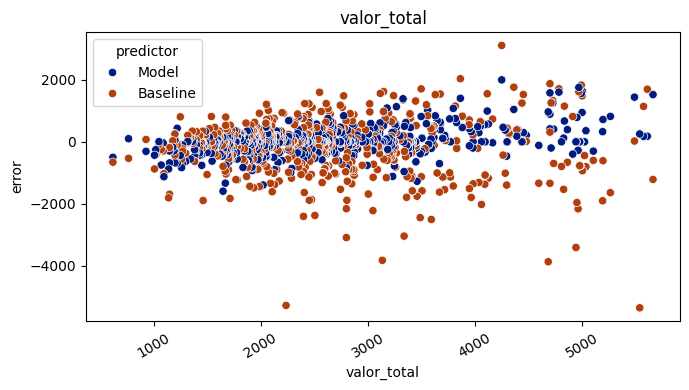

In [147]:
utils.plot_matrix(
    data=data_test_comparation,
    columns_features=['valor_total'],
    plot=sns.scatterplot,
    loop_feature='x',
    plot_kwargs={'y': 'error', 'hue':'predictor'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    save_image=True,
    nome_imagem='Erro vs Valor Total - Model vs Baseline'
)



Gráfico salvo em: images/Historgrama de Erros - Model vs Baseline.png


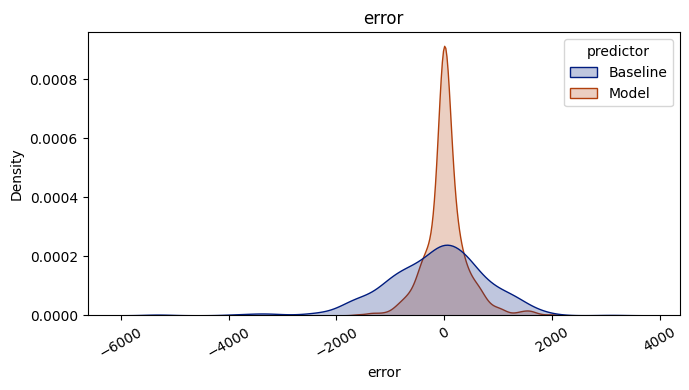

In [146]:
utils.plot_matrix(
    data=data_test_comparation,
    columns_features=['error'],
    plot=sns.kdeplot,
    loop_feature='x',
    plot_kwargs={'hue': 'predictor', 'fill':'true'},
    n_cols=1,
    n_rows=1,
    figsize=(7, 4),
    label=False,
    save_image=True,
    nome_imagem='Historgrama de Erros - Model vs Baseline'
)

## Shap Analysis

In [63]:
X_train = utils.preparacao_dos_dados(df=data_train_replic, dict_preparation=dict_preparation_final, is_train=True)
X_test = utils.preparacao_dos_dados(df=data_test, dict_preparation=dict_preparation_final, is_train=False)

In [61]:
explainer = shap.Explainer(best_model)

In [64]:
shap_values = explainer(X_test[features_selected])

In [69]:
utils.save_picked_file(file=shap_values, name='shap_values')

### Summary

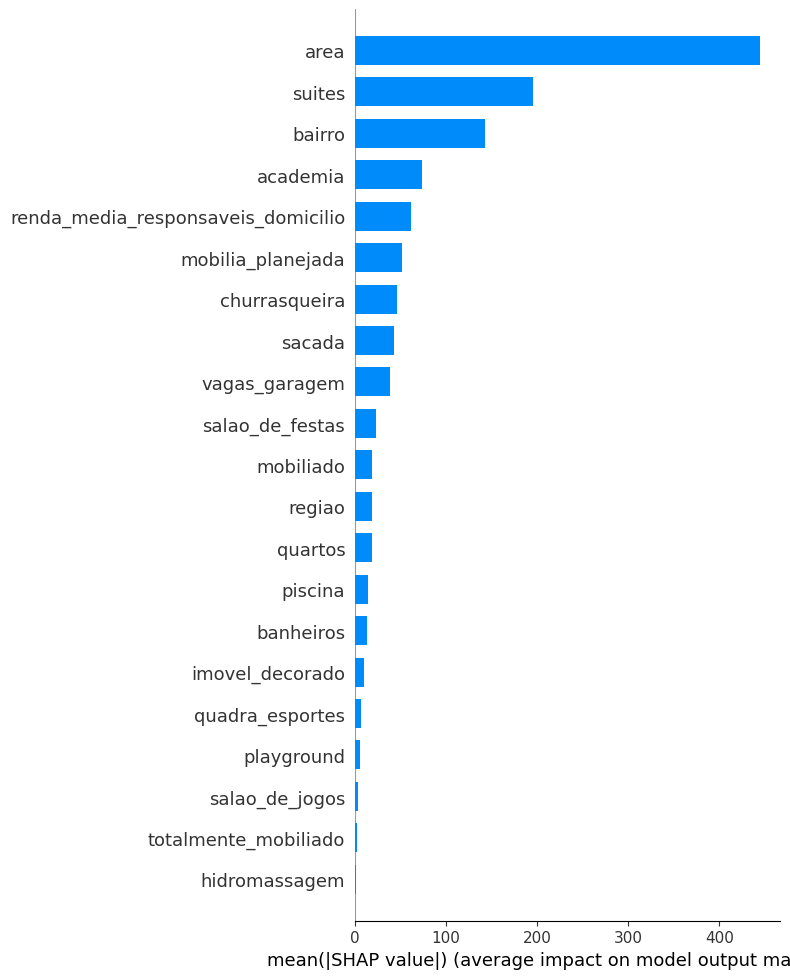

In [66]:
shap.summary_plot(shap_values, plot_type='bar', max_display=30)

### Watterfall

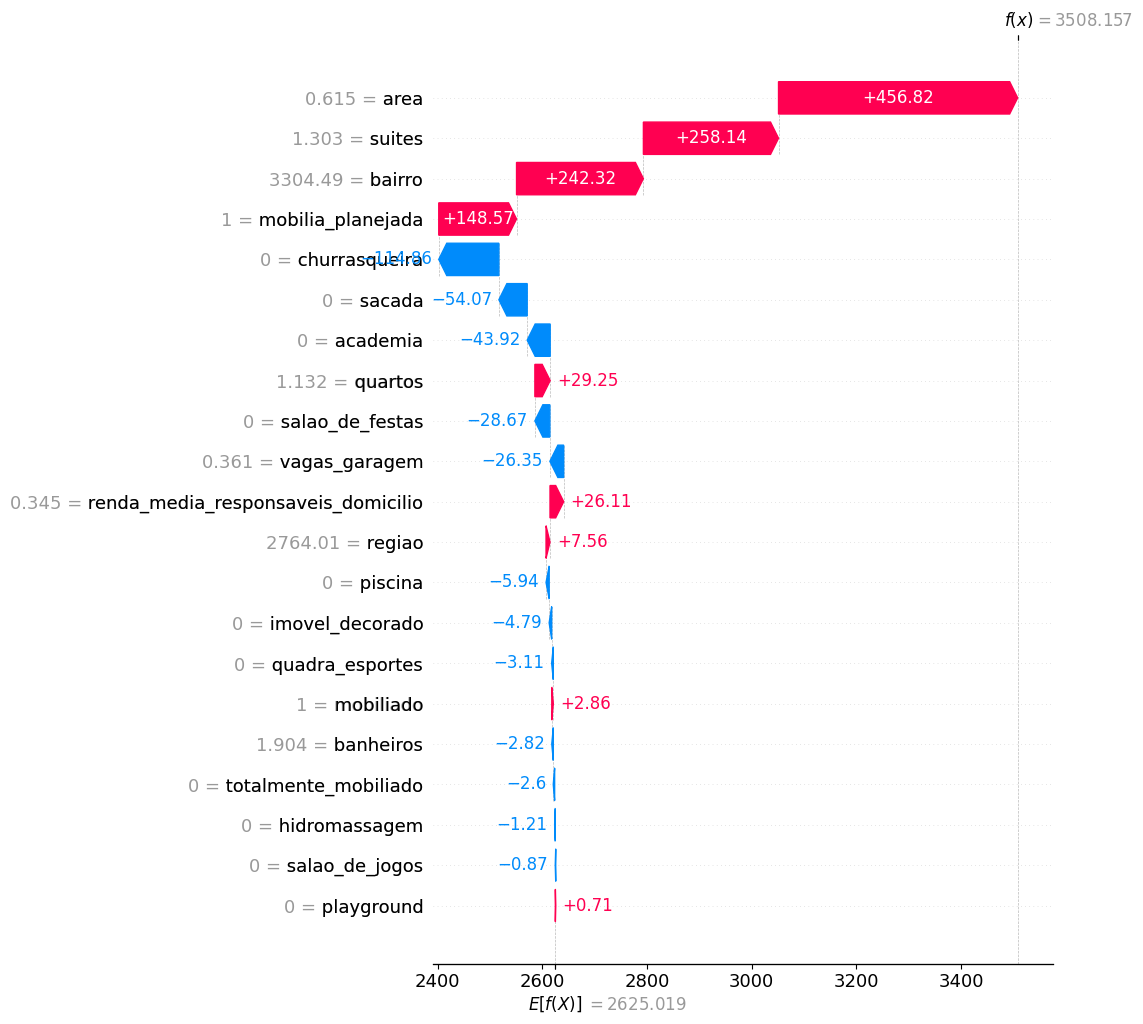

In [67]:
shap.plots.waterfall(shap_values[103], max_display=40)

### Beeswarm

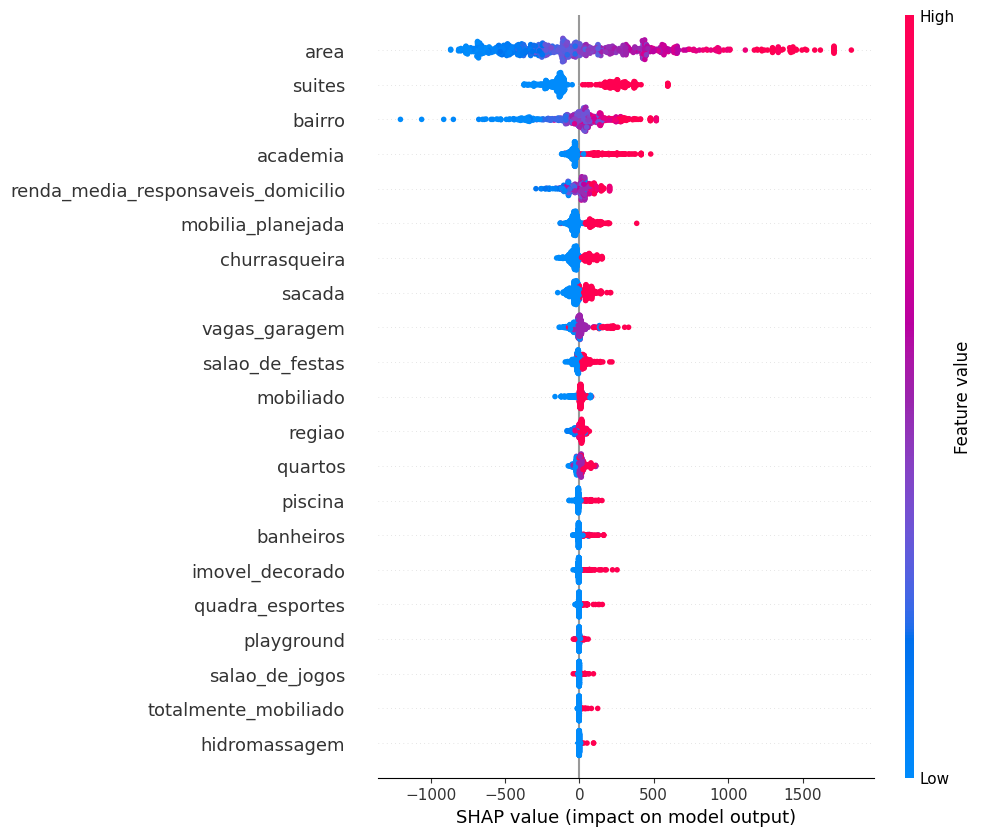

In [68]:
shap.plots.beeswarm(shap_values, max_display=40)

### Investigação dos erros

In [71]:
data_validation_cv.loc[(data_validation_cv['error'] > -1000) ].reset_index().sort_values('error')

,index,site,data_coleta,titulo,link,endereco,cidade,bairro,aluguel,condominio,iptu,area,quartos,suites,banheiros,vagas_garagem,mobiliado,mobilia_planejada,piscina,academia,sacada,churrasqueira,salao_de_festas,salao_de_jogos,espaco_coworking,quadra_esportes,playground,lavanderia,espaco_pet,imovel_decorado,totalmente_mobiliado,hidromassagem,valor_total,year,month,day,week_of_year,year_week,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,latitude,longitude,regiao,area_bairro,qtd_homens,qtd_mulheres,total,qtd_domicilios_particulares,renda_media_responsaveis_domicilio,area_media_por_domicilio_particular,preco_m2_por_bairro,cluster,prediction,error
197,7505,Cilar,2025-03-22,Apartamento com 2 quartos,https://cilar.com.br/alugar/apartamento-com-2-...,"Avenida José Gulin, nº 373, - Bacacheri - Curi...",Curitiba,bacacheri,2900.0,863.0,0.0,54.0,2,1,1,1,Não,Não,Não,Sim,Sim,Sim,Sim,Não,Não,Não,Sim,Sim,Não,Não,Não,Não,3763.0,2025,3,22,12,2025-11,1.0,6.123234e-17,-0.994522,-0.104528,0.992709,0.120537,-25.395628,-49.224324,Boa Vista,6.98,10762,12344,23106,7107,3029.00,0.000982,31.774608,1,2800.910645,-962.089355
152,7455,Cilar,2025-03-21,Apartamento no 2º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-2-a...,"Rua João Alencar Guimarães, 2580 - Campo Compr...",Curitiba,campo comprido,3500.0,660.0,70.0,75.0,3,1,1,2,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,4230.0,2025,3,21,12,2025-11,1.0,6.123234e-17,-0.951057,-0.309017,0.992709,0.120537,-25.462230,-49.328531,Fazendinha-Portão,8.55,10264,11374,21638,6649,1216.71,0.001286,33.408619,6,3275.060059,-954.939941
439,7772,Cilar,2025-03-22,Apartamento no 13º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-13-...,"Rua João Geara, 127 - Portão - Curitiba",Curitiba,portao,3800.0,590.0,186.0,115.0,3,1,1,2,Sim,Não,Sim,Sim,Não,Não,Sim,Sim,Não,Sim,Não,Sim,Não,Não,Não,Não,4576.0,2025,3,22,12,2025-11,1.0,6.123234e-17,-0.994522,-0.104528,0.992709,0.120537,-25.466997,-49.291536,Fazendinha-Portão,5.70,19092,21643,40735,13183,1722.89,0.000432,36.661758,6,3662.730225,-913.269775
355,7677,Cilar,2025-03-22,Apartamento com 3 quartos,https://cilar.com.br/alugar/apartamento-com-3-...,"Rua Guilherme Pugsley, 1950 - Água Verde - Cur...",Curitiba,agua verde,2997.0,955.0,204.0,155.0,3,1,1,1,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,4156.0,2025,3,22,12,2025-11,1.0,6.123234e-17,-0.994522,-0.104528,0.992709,0.120537,-25.463781,-49.289690,Fazendinha-Portão,4.76,22546,27320,49866,17045,3332.57,0.000279,30.128985,1,3250.795410,-905.204590
354,7676,Cilar,2025-03-22,Apartamento no 2º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-2-a...,"Rua Floriano Essenfelder, 196 - Alto da Glória...",Curitiba,alto da gloria,2950.0,500.0,0.0,72.0,1,0,1,1,Sim,Não,Não,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,3450.0,2025,3,22,12,2025-11,1.0,6.123234e-17,-0.994522,-0.104528,0.992709,0.120537,-25.422696,-49.258505,Matriz,0.88,2513,3075,5588,2125,3263.47,0.000414,36.350384,0,2545.794434,-904.205566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,7491,Cilar,2025-03-22,Apartamento no 5º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-5-a...,"R BRIGADEIRO FRANCO, 927 - BIGORRILHO - Curitiba",Curitiba,bigorrilho,2500.0,836.0,0.0,74.0,1,1,0,1,Sim,Sim,Não,Sim,Sim,Sim,Não,Não,Sim,Não,Não,Sim,Não,Sim,Não,Não,3336.0,2025,3,22,12,2025-11,1.0,6.123234e-17,-0.994522,-0.104528,0.992709,0.120537,-25.452835,-49.271233,Matriz,3.50,12359,14768,27127,9937,3792.68,0.000352,35.096823,4,4636.360840,1300.360840
440,7773,Cilar,2025-03-22,Apartamento no 2º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-2-a...,"Rua Monsenhor Manoel Vicente, 532 - Água Verde...",Curitiba,agua verde,3750.0,743.0,256.0,190.0,3,1,2,2,Sim,Não,Não,Sim,Sim,Sim,S

https://www.apolar.com.br/alugar/curitiba/juveve/alugar-residencial-apartamento-curitiba-juveve-106756
- Tem espaço pet e outras comodidades que não são citadas

https://www.apolar.com.br/alugar/curitiba/bigorrilho/alugar-residencial-apartamento-curitiba-bigorrilho-107350
- Descrição não apresenta mobilias do apartamento


https://cilar.com.br/alugar/apartamento-no-3-andar-com-2-quartos-sao-francisco-curitiba/id/83569735/code/36801.002

https://cilar.com.br/alugar/apartamento-no-12-andar-com-3-quartos-novo-mundo-curitiba/id/83667386/code/39899.001

https://cilar.com.br/alugar/apartamento-no-3-andar-com-2-quartos-sao-francisco-curitiba/id/83569735/code/36801.002

https://cilar.com.br/alugar/apartamento-no-3-andar-com-2-quartos-reboucas-curitiba/id/81450384/code/206776

https://cilar.com.br/alugar/apartamento-no-5-andar-com-2-quartos-agua-verde-curitiba/id/83650546/code/AP0146

Novos atributos?
bike parking, espaço pet, sala coworking,
quadra de esportes e playground
ar-condicionado
chuveiro a gás, lavanderia

contém 2 quartos mobiliado com cama box casal e solteiro, armário planejado, cozinha com armários e fogão cooktop, geladeira, sala com sofá, rack e mesa com 04 cadeiras, social com armário e box em vidro.

- bike parking
- espaço pet
- sala coworking
- quadra de esportes
- playground
- lavanderia
- Pet Space
- Salão de Jogos

- ar condicionado
- chuveiro a gás
- cama, armario, fogão, geladeira, sofá, rack, mesa, cadeiras
- decorado
- armarios planejados


-- imóvel parece estar caro:
https://cilar.com.br/alugar/apartamento-no-5-andar-com-2-quartos-centro-curitiba/id/81833185/code/213381

-- Descrição pobre. O imóvel parece estar caro
https://cilar.com.br/alugar/apartamento-com-1-quarto-centro-curitiba/id/77041048/code/AP5ELI08

-- Imóvel com móveis luxuosos
https://cilar.com.br/alugar/apartamento-no-2-andar-com-3-quartos-agua-verde-curitiba/id/81344565/code/04889.003

-- banheiro -1
https://cilar.com.br/alugar/apartamento-no-2-andar-com-3-quartos-bacacheri-curitiba/id/83220677/code/AP1053

## Fine Tuning

In [253]:
import optuna

In [258]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 100)
    min_samples_split = trial.suggest_float('min_samples_split',0,0.3)
    min_samples_leaf = trial.suggest_float('min_samples_leaf',0,0.2)
    # criterion = trial.suggest_categorical('criterion', ["squared_error", "absolute_error", "friedman_mse","poisson"])
    # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 1])

    
    # model definition
    rf = en.RandomForestRegressor( n_estimators     = n_estimators, 
                                  max_depth         = max_depth,
                                  # min_samples_split = min_samples_split,
                                  # min_samples_leaf  = min_samples_leaf
                                  # criterion        = criterion,
                                #   max_features     = max_features
                                 ) 
    
    models = {
        'Random Forest': rf
    }

    df_results = cross_validation(data=data_train, dict_models=models, k_fold=11, len_validation = 1000)

    # # model fit
    # rf.fit(X_train,y_train)

    # # ==== Model Prediction 
    # # model prediction
    # y_pred_xgb = rf.predict(X_validation[features_selected])
    
    return df_results.loc['Random Forest', 'MAE']

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2024-11-23 11:33:24,162] A new study created in memory with name: no-name-ac9cd193-545f-45df-9a99-1b3317a1e721


Random Forest


[I 2024-11-23 11:33:55,128] Trial 0 finished with value: 403.1750413274367 and parameters: {'n_estimators': 85, 'max_depth': 81, 'min_samples_split': 0.28690997821344605, 'min_samples_leaf': 0.1041994589207695}. Best is trial 0 with value: 403.1750413274367.


Random Forest


[W 2024-11-23 11:34:09,219] Trial 1 failed with parameters: {'n_estimators': 58, 'max_depth': 63, 'min_samples_split': 0.14720547932077552, 'min_samples_leaf': 0.17071543566871916} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/arthur/venv/monografia-env/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3761/3168145885.py", line 23, in objective
    df_results = cross_validation(data=data_train, dict_models=models, k_fold=11, len_validation = 1000)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3761/1324772688.py", line 15, in cross_validation
    model.fit(X_train_cv, y_train_cv)
  File "/home/arthur/venv/monografia-env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kw

KeyboardInterrupt: 

In [ ]:
# {'n_estimators': 96, 'max_depth': 14}